<h1 style="font-size: 40px;">Studying Galaxy Evolution with SDSS and 3D-HST surveys</h1>

<br>
The SDSS catalogue contains photometric measurements in 5 optical bands for a large number of galaxies. We have processed this data with the CIGALE software (Code Investigation GALaxy Emission) which generates model SEDs with stellar populations synthesis. 

<br><br>

<div style="text-align:center;">
    <img src="images/sdss.png" width="40%" style="display:inline-block" />
    <img src="images/cigale_principle.png" width="50%" style="display:inline-block" />
</div>

To explore more distant galaxies (z>1), you will also find a catalogue obtained in a smaller area (~ 1
square deg) with the Hubble Space Telescope: the 3D-HST survey catalogue (up to z~3).



In [1]:
import numpy as np
import math 
import scipy.stats as stats
import statistics
import random
#from scipy import special
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors

from scipy.integrate import quad

import scipy
#import SDDlib as sdd
#%matplotlib notebook
from tqdm import tqdm
#plt.rcParams['figure.figsize'] = [8, 8]

from astropy.coordinates import FK5, SkyCoord
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import Planck13, z_at_value
from astropy import units as u
#from pcigale.sed import SED
#from pcigale.sed import utils
#from pcigale.sed_modules import get_module



In [2]:
# constants cgs

G = 6.67259 * 10**-8 #G in cgs

h = 6.63*10**(-27) #erg s 
c = 2.9979*10**(10) #cm s^-1
m_p = 1.67262192 * 10**(-24) #g
kb = 1.38 * 10**(-16) #erg/K
E_ion_hydrogen = 13.6 * 1.60218e-12
#E_Ly_alpha = 10.2 * 1.60218e-12
#E_Ly_beta = 12.1 * 1.60218e-12

M_sun = 1.9891 * 10**33 #solar mass in g
R_sun = 6.9598 * 10**10 #solar radius in cm 
T_sun_eff = 5772 #Sun surface temperature in K
M_earth = 5.976 * 10**27 #earth mass in g
R_earth = 6.378 * 10**8 #earth radius in cm
ly = 9.463 * 10**17 #light year in cm
parsec = 3.086 * 10**18 #parsec in cm
Mpc = 3.086 * 10**24 #cm
AU = 1.496 * 10**13 #astronomical unit in cm

H0 = 2.176*10**(-18) #Hubble constant, s^-1

Gyr = 3.1536*10**16

In [25]:
import numpy as np
from astropy.table import Table

# Reading data from the SDSS photometric catalogue
sdss_photo = Table.read('FITS/SDSS_LAB2024_photometry.fits')
sdss_spec = Table.read('FITS/SDSS_LAB2024_spectroscopy.fits')
cigale_fit_results = Table.read('FITS/SDSS_LAB2024_CIGALEresults.fits')

id = sdss_photo['id']
redshift = sdss_photo['redshift']
ra, dec = sdss_photo['ra'], sdss_photo['dec']

# Reading and calculating density
with open("FITS/environment_density.txt", "r") as read_file:
    N = np.array([float(env) for env in read_file.read().split()])
density = N / (np.pi * 0.5**2)

# Extracting data from CIGALE results
SFR_bayes = cigale_fit_results['bayes_sfh_sfr']
stellar_mass_bayes = cigale_fit_results['bayes_stellar_m_star']
SFR_best = cigale_fit_results['best_sfh_sfr']
stellar_mass_best = cigale_fit_results['best_stellar_m_star']
age = cigale_fit_results['best_sfh_age']

# Calculate specific star formation rates (sSFR)
sSFR_bayes = np.divide(SFR_bayes, stellar_mass_bayes, where=stellar_mass_bayes > 0)
sSFR_best = np.divide(SFR_best, stellar_mass_best, where=stellar_mass_best > 0)

# Spectral line fluxes and errors
lines_flux = {
    'H_alpha': sdss_spec["h_alpha_flux"],
    'H_beta': sdss_spec["h_beta_flux"],
    'OII_3726': sdss_spec['oii_3726_flux'],
    'OII_3729': sdss_spec['oii_3729_flux'],
    'OIII_5007': sdss_spec["oiii_5007_flux"],
    'NII_6584': sdss_spec["nii_6584_flux"],
    'SII_6717': sdss_spec["sii_6717_flux"],
    'SII_6731': sdss_spec["sii_6731_flux"]
}

lines_errors = {
    'H_alpha_err': sdss_spec['h_alpha_flux_err'],
    'H_beta_err': sdss_spec['h_beta_flux_err'],
    'OII_3726_err': sdss_spec['oii_3726_flux_err'],
    'OII_3729_err': sdss_spec['oii_3729_flux_err'],
    'OIII_5007_err': sdss_spec['oiii_5007_flux_err'],
    'NII_6584_err': sdss_spec['nii_6584_flux_err'],
    'SII_6717_err': sdss_spec['sii_6717_flux_err'],
    'SII_6731_err': sdss_spec['sii_6731_flux_err']
}

metallicity = sdss_spec["log_oh"]


# and from the 3DHST catalogue
_3DHST_fits = Table.read('FITS/3DHST_catalogue.fits')

id_3DHST = _3DHST_fits['ID']
redshift_3DHST = _3DHST_fits['redshift']
age_3DHST = 10**(_3DHST_fits['Log_age_yr'])
SFR_3DHST = 10**(_3DHST_fits['Log_SFR_Msun_yr'])
stellar_mass_3DHST = 10**(_3DHST_fits['Log_Mstar_Msun'])

# Calculate sSFR for 3DHST
sSFR_3DHST = np.divide(SFR_3DHST, stellar_mass_3DHST, where=stellar_mass_3DHST > 0)


In [26]:
import pandas as pd

# Convert Astropy Tables to pandas DataFrames
df_sdss_photo = sdss_photo.to_pandas()
df_sdss_spec = sdss_spec.to_pandas()
df_cigale_results = cigale_fit_results.to_pandas()
df_3DHST = _3DHST_fits.to_pandas()

# Display the first few rows of each DataFrame
print("SDSS Photometry Data:")
print(df_sdss_photo.head(5).to_string(index=False), "\n")

print("SDSS Spectroscopy Data:")
print(df_sdss_spec[['id','h_alpha_flux', 'h_beta_flux', 'oii_3726_flux', 'oii_3729_flux',"oiii_5007_flux","nii_6584_flux","sii_6717_flux","sii_6731_flux"]].head(5).to_string(index=False), "\n")

print("CIGALE Fit Results:")
print(df_cigale_results[['id','bayes_sfh_sfr','bayes_stellar_m_star','best_sfh_sfr','best_stellar_m_star','best_sfh_age']].head(5).to_string(index=False), "\n")

print("3DHST Catalogue Data:")
print(df_3DHST[['ID', 'redshift', 'Log_age_yr', 'Log_SFR_Msun_yr', 'Log_Mstar_Msun']].head(5).to_string(index=False))


SDSS Photometry Data:
                 id         ra       dec  redshift  sdss.up  sdss.up_err  sdss.gp  sdss.gp_err  sdss.rp  sdss.rp_err  sdss.ip  sdss.ip_err  sdss.zp  sdss.zp_err
1237657873254907919 140.153626 39.308208  0.028312 0.119670     0.020435 1.029917     0.012816 1.621148     0.022931 1.954847     0.023217 2.286192     0.059580
1237657873254973544 140.325684 39.456471  0.056195 0.091612     0.006626 0.247744     0.003121 0.358206     0.004741 0.453588     0.007278 0.492240     0.025029
1237654880726286453 190.287293  5.309674  0.074970 0.045000     0.004752 0.214703     0.004054 0.462379     0.007594 0.667785     0.011125 0.835854     0.022765
1237654880727728243 193.587524  5.282654  0.048760 0.466016     0.013479 1.720028     0.006990 2.967451     0.009481 4.098367     0.018062 4.911618     0.059197
1237654880728842356 196.179871  5.124015  0.054671 0.147323     0.008597 0.379945     0.003792 0.529207     0.006502 0.663836     0.009359 0.737546     0.032889 

SDSS Spect

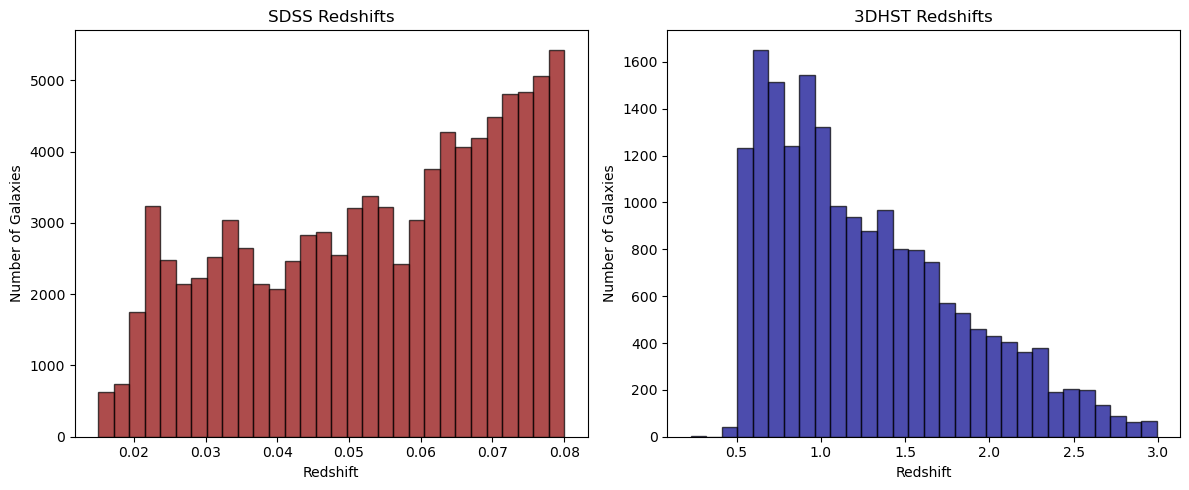

In [13]:
import matplotlib.pyplot as plt

# Set up the figure and axis for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) #, sharey=True

# Plot histogram for SDSS redshifts
axes[0].hist(redshift, bins=30, color='darkred', alpha=0.7, edgecolor='black')
axes[0].set_title('SDSS Redshifts')
axes[0].set_xlabel('Redshift')
axes[0].set_ylabel('Number of Galaxies')

# Plot histogram for 3DHST redshifts
axes[1].hist(redshift_3DHST, bins=30, color='darkblue', alpha=0.7, edgecolor='black')
axes[1].set_title('3DHST Redshifts')
axes[1].set_xlabel('Redshift')
axes[1].set_ylabel('Number of Galaxies')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Best vs Bayes

**Best Result (Maximum Likelihood Best Fit):**

Is typically the set of parameters that maximizes the likelihood function. In simpler terms, it finds the parameters that best explain the observed data assuming a particular model. Achieved by minimizing a cost function, such as chi-squared $\chi^2$, or maximizing the likelihood function. Often done using optimization techniques such as least-squares fitting.

- Provides a single best-fit solution.
- Can be sensitive to noise or outliers in the data.
- Doesn't naturally account for parameter uncertainties or prior knowledge.

**Bayes:**

Based on the posterior distribution obtained through Bayes' theorem:

$$P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)}$$

Where:
- $P(\theta | D)$: Posterior distribution of the parameters \(\theta\) given the data \(D\).
- $P(D | \theta)$: Likelihood of the observed data given the parameters.
- $P(\theta)$: Prior distribution representing prior knowledge of the parameters.
- $P(D)$: Evidence (normalization constant), ensuring the posterior integrates to 1.

$$P(D) = \int P(D | \theta) P(\theta) \, d\theta$$

1. Bayesian Mean (Expected Value)
   
   $$\theta_{\text{Bayesian Mean}} = \int \theta P(\theta | D) \, d\theta$$
   

2. Bayesian Variance
   
   $$\sigma^2_\theta = \int (\theta - \mu_\theta)^2 P(\theta | D) \, d\theta$$
   

3. Maximum A Posteriori (MAP): the value $\theta_\text{MAP}$ that maximizes the posterior distribution:
     
     $$\theta_{\text{MAP}} = \arg \max_\theta P(\theta | D)$$
     
In practice, these integrals are often difficult to compute analytically due to the complexity of the likelihood or prior functions. Numerical methods such as **Markov Chain Monte Carlo (MCMC)** are commonly used to approximate these integrals by sampling from the posterior distribution.

# Empirical SFR: the Kennicut-Schmidt law

Stellar mass is built up by the star formation rate ($SFR$) over time from an initial time $t_0$:

$$ m_*(t) = \int_{t_0}^t SFR(t') dt' $$ 

The star formation rate, $SFR(t)$, is modeled as proportional to the gas mass m_{gas}(t) raised to the power of alpha, with a star formation efficiency factor, $\epsilon(t)$:

$$ SFR(t) = \epsilon(t) m_{gas}^\alpha(t) $$ 

The **Kennicut-Schmidt** empirical law states that the star formation rate ($SFR$) is proportional to the gas mass $m_{gas}(t)$ ($\alpha=1$) and inversely proportional to the dynamical time scale ($\tau_{dyn}$):

$$ SFR(t) = \frac{\epsilon'}{\tau_{dyn}} m_{gas}(t) $$ 

where $\epsilon'\sim 0.02$ is a constant that regulates the rate of gas consumption and $t_{dyn}$ is the time scale for the gas in the galaxy to collapse toward the center of the galaxy. 

$$ t_{dyn} = 2 \times 10^7 \, \text{yr} \left(\frac{R_{1/2}}{4 \, \text{kpc}}\right) \left(\frac{V_c}{200 \, \text{km/s}}\right)^{-1} $$ 

Deviding for the total area of the galaxy:

$$ \dot{\Sigma}_* = \frac{\dot{M}_*}{M_\text{GMC}} f_{H_2}\Sigma_\text{gas} $$ 

Left: first Kennicut-Shmidt plot, unresolved (averaged on all galaxy). Center: spatially resolved KS law (ALMA, VLT). Right: KS for only molecular hydrogen. No SFR is possible below a H2 threshold. 

<div style="text-align:center;">
    <img src="images/kennicut_unresolved.png" width="30%" style="display:inline-block" />
    <img src="images/kennicut_resolved.png" width="30%" style="display:inline-block" />
    <img src="images/kennicut_H2.png" width="30%" style="display:inline-block" />
</div>


**Tully-Fisher**

The Tully-Fisher relation connects the galaxy's circular velocity $V_c$ with its stellar mass $M$, indicating that more massive galaxies tend to have higher circular velocities:

$$ \log(M_\odot) = 3.60 \cdot \log\left(\frac{V_c}{v_{\text{ref}}}\right) + 10.50 $$ 


**SIZE-MASS RELATION**

The size-mass relation connects the effective radius ($R_{eff}$) of a galaxy to its stellar mass $M_*$, with A being a constant and $\alpha$ approximately equal to 0.22.

$$ \frac{R_{\text{eff}}}{\text{kpc}} = A \left(\frac{M_*}{5 \times 10^{10} M_\odot}\right)^\alpha $$ 

The circular velocity and the effective radius scale more or less the same way with mass. This implies that the dynamical time is approximately constant for a range of galaxies.

<div style="text-align:center;">
    <img src="images/tully_fisher.png" width="30%" style="display:inline-block" />
    <img src="images/mass_size.png" width="50%" style="display:inline-block" />
</div>


**Metallicty**

Relative abundance of elements heavier than He.
There is GAS PHASE metallicity (metals abundance in the ISM, visible in emission) and STELLAR METALLICITY (metals embedded in stars, visible in absorption).

$$Z= \frac{[Z]}{[H]}$$

With this definition $1 = X + Y + Z$, where $X$ is the mass fraction of Hydrogen and $Y$ is the mass fraction of Helium. $Z_\odot = 0.020$. 

Another definition is: $12 + log(O/H)$. In this units $Z_\odot = 8.69$. 7.69 is 10% less metals compraed to the Sun, 9.69 is ten times more metals. 

It is possible to measure metallicities in the gas phase by comparing hydrogen lines to lines of heavy metals. Considering e.g. [OIII] as an example:

$$\frac{I([OIII]5008)}{I(H\beta)} = \frac{n_en_{O^{++}}f(q,A)hv_{5008}}{n_en_{H^+}\alpha_{eff}hv_{H\beta}}$$

where $f(q,A)$ is a complex function that describes the detailed balance of collisions and recombinations, hence depending on temperature). Another line very usefull for metaliccity determination is $N_2$.

<div style="text-align:center;">
    <img src="images/metallicity_calibration.png" width="60%" style="display:inline-block" />
</div>






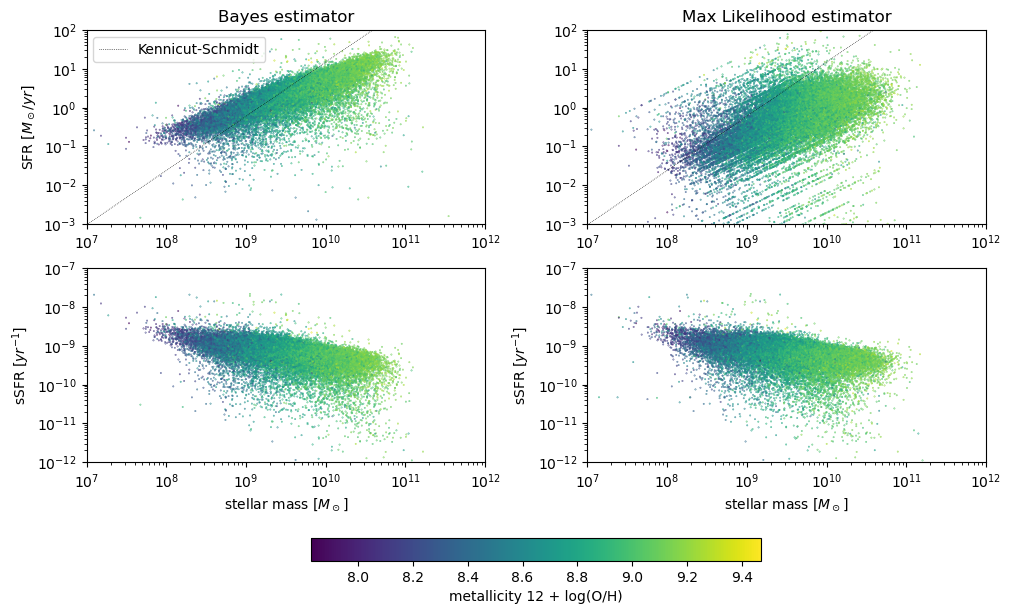

In [27]:
# SFR and sSFR vs Stellar Mass, Metallicity 

fig, axes = plt.subplots(2, 2, figsize=(10,6),layout="constrained") 

S = axes[0,0].scatter(stellar_mass_bayes[metallicity>-9999],SFR_bayes[metallicity>-9999], c=metallicity[metallicity>-9999], s=0.1, cmap='viridis')
axes[0,0].set(xscale = 'log', yscale = 'log', xlim = (1e7,1e12), ylim = (1e-3,1e2)) 
axes[0,0].set_ylabel("SFR [$M_\odot/yr$]") 
axes[0,0].set_title("Bayes estimator")

x = np.logspace(7,12)
axes[0,0].plot(x, 1.5*1e-13 * x**1.4,label="Kennicut-Schmidt", c='black',linestyle=':',linewidth=0.5)
axes[0,0].legend()

axes[0,1].scatter(stellar_mass_best[metallicity>-9999],SFR_best[metallicity>-9999], c=metallicity[metallicity>-9999], s=0.1,cmap='viridis')
axes[0,1].set(xscale = 'log', yscale = 'log', xlim = (1e7,1e12), ylim = (1e-3,1e2)) 
axes[0,1].set_title("Max Likelihood estimator")

x = np.logspace(7,12)
axes[0,1].plot(x, 1.5*1e-13 * x**1.4,label="Kennicut-Schmidt", c='black',linestyle=':',linewidth=0.5)

axes[1,0].scatter(stellar_mass_bayes[metallicity>-9999],sSFR_bayes[metallicity>-9999],c=metallicity[metallicity>-9999], s=0.1,cmap='viridis')
axes[1,0].set(xscale = 'log', yscale = 'log', xlim = (1e7,1e12), ylim = (1e-12,1e-7)) 
axes[1,0].set_xlabel("stellar mass [$M_\odot$]") 
axes[1,0].set_ylabel("sSFR [$yr^{-1}$]")

axes[1,1].scatter(stellar_mass_best[metallicity>-9999],sSFR_bayes[metallicity>-9999],c=metallicity[metallicity>-9999], s=0.1,cmap='viridis')
axes[1,1].set(xscale = 'log', yscale = 'log', xlim = (1e7,1e12), ylim = (1e-12,1e-7)) 
axes[1,1].set_xlabel("stellar mass [$M_\odot$]") 
axes[1,1].set_ylabel("sSFR [$yr^{-1}$]")

fig.colorbar(S, ax=axes, location='bottom', shrink=0.5, label='metallicity 12 + log(O/H)') 
plt.show()



More massive galaxies have higher metallicity than low mass galaxies. Why? The more obvious explanation is that high mass galaxies have formed stars for a longer time, and subsequent stellar populations have polluted the ISM more and more.

## Galaxy Metallicity Relations and the Fundamental Metallicity Relation

Local galaxies exhibit a tight correlation between stellar mass and gas-phase metallicity, known as the **mass-metallicity relation**. Closed box models (where all the metals produced by stars are retained inside a galaxy) would predict, however, a correlation of metallicity with the inverse of the gas fraction, $f_{\text{gas}}$. 

In cases where the effective yield, defined as:

$$y_{\text{eff}} = \frac{Z_\text{obs}}{\ln(f_{\text{gas}})}$$

is equal to the true nucleosynthetic yield, these models would apply. However, it is found that $y_{\text{eff}} < y_{\text{true}}$, which suggests that the origin of the steep correlation is explained by a selective loss of metals from galaxies with shallow potential wells via **galactic winds**.

A second correlation, known as the **fundamental metallicity relation** exists between mass, star formation rate (SFR), and metallicity. In this 3D space, galaxies lie in a **fundamental plane**, which can then be projected into both the mass-metallicity relation and the SFR-mass relation. 

This implies a correlation between metallicity and SFR. The FMR can be explained by:

- **Infall** of metal-poor gas, which shapes the trend of metallicity with SFR.
- **Outflow** of metal-rich material, which leads to the dependence on stellar mass.

The combination of these two effects with the **Schmidt-Kennicutt law** leads to the FMR.

<div style="text-align:center;">
    <img src="images/FMR.png" width="40%" style="display:inline-block" />
    <img src="images/metal_yield.png" width="40%" style="display:inline-block" />
</div>

/tmp/ipykernel_18538/478906216.py:16: RuntimeWarning: invalid value encountered in log10
  c=np.log10(SFR_bayes_valid),cmap='viridis',  vmin=-3,vmax=1,s=10)


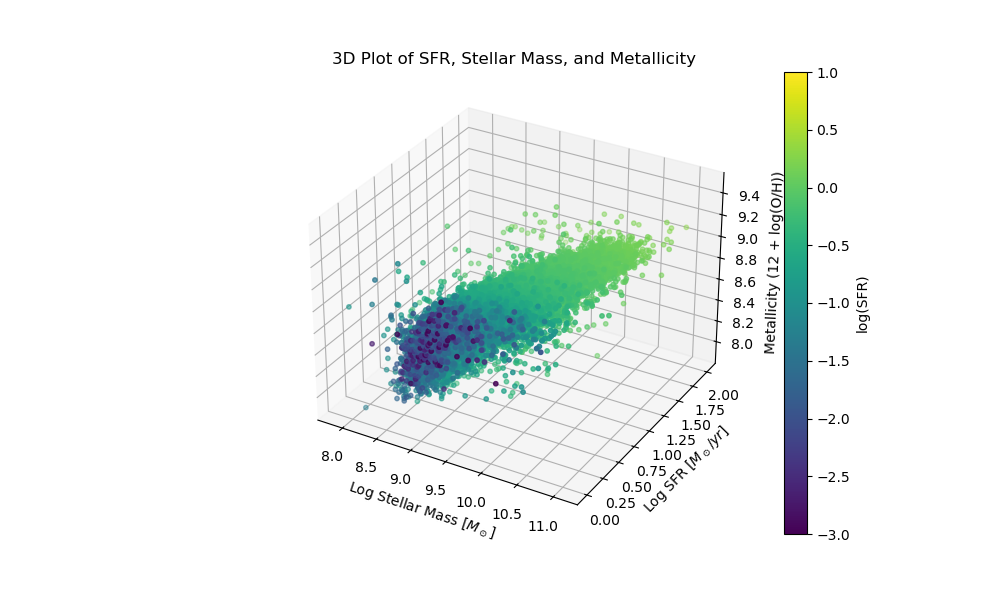

In [35]:
#%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

# Remove invalid values (e.g., -9999 values for metallicity)
valid_data = metallicity > -9999
stellar_mass_bayes_valid = np.log10(stellar_mass_bayes[valid_data])
SFR_bayes_valid = np.log10(SFR_bayes[valid_data])
metallicity_valid = metallicity[valid_data]

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color based on the log of SFR
sc = ax.scatter(stellar_mass_bayes_valid, SFR_bayes_valid, metallicity_valid, 
                c=np.log10(SFR_bayes_valid),cmap='viridis',  vmin=-3,vmax=1,s=10)

# Labels and title
ax.set_xlabel('Log Stellar Mass [$M_\odot$]')
ax.set_ylabel('Log SFR [$M_\odot/yr$]')
ax.set_zlabel('Metallicity (12 + log(O/H))')
ax.set_title('3D Plot of SFR, Stellar Mass, and Metallicity')

# Colorbar
fig.colorbar(sc, ax=ax, label='log(SFR)')

plt.show()

# Evolution

Next equation describes the evolution of the gas mass $m_\text{gas}(t)$. The gas decreases due to star formation ($SFR(t)$), and increases due to inflows ($dot{m_\text{gas}}^{in}$) and decreases due to outflows ($dot{m_\text{gas}}^{out}$). $R$ is a factor that accounts for re-incorporation of gas that was previously ejected:

$$ \frac{dm_{gas}}{dt}(t) = -SFR(t) + R \cdot SFR(t) + \dot{m_{gas}}^{in}(t) - \dot{m_{gas}}^{out}(t) $$ 

The evolution of metal mass, m_Z(t), is driven by stellar nucleosynthesis (y * SFR(t)) and the outflow of metals (Z * SFR(t)), along with any inflows or outflows of metals:

$$ \frac{dm_{Z}}{dt}(t) = y \cdot SFR(t) - Z \cdot SFR(t) + \dot{m_{Z}}^{in}(t) - \dot{m_{Z}}^{out}(t) $$ 


**Closed box model**: assume no inflows or outflows ($\dot{m_\text{gas}}^{in} = \dot{m_\text{gas}}^{out} = 0$) and $R = 0$ for simplicity. The gas mass decreases only due to star formation. The gas mass evolves exponentially over time, starting from an initial gas mass $m_\text{gas}(t_0)$ at time $t_0$. 

$$ m_{gas}(t) = m_{gas}(t_0) e^{-\epsilon'(t - t_0)} $$ 

The star formation rate also follows an exponential decay, depending on the amount of gas available:

$$ SFR(t) = \epsilon' m_{gas}(t_0) e^{-\epsilon'(t - t_0)} $$ 

The stellar mass $m_*(t)$ at time t is the cumulative star formation over time, given that gas is consumed by star formation:

$$ m_*(t) = m_{gas}(t_0) [1 - e^{-\epsilon'(t - t_0)}] $$ 


% METALLICITY

$$ \frac{d(M_z)}{dt}(t) = y \cdot SFR(t) - Z \cdot SFR(t) = y \cdot SFR(t) - \frac{M_Z(t)}{M_{\text{gas}}(t)} SFR(t) = y \cdot SFR(t) - \epsilon' M_Z(t) $$ 
% This equation describes how the metal mass (M_z) evolves in time. Metals are produced by stars (y * SFR(t)) and lost to the interstellar medium (proportional to M_z(t)).

% Cauchy non-homogeneous differential equation:

$$ M_Z(t) = \left[\int e^{\epsilon'(t - t_0)} y \, SFR(t) dt \right] e^{-\epsilon'(t - t_0)} $$ 
% This is a solution to the differential equation that describes how metal mass evolves in time, including the effects of star formation and metal loss.

$$ M_Z(t) = y \epsilon' m_{\text{gas}}(t_0) (t - t_0) e^{-\epsilon'(t - t_0)} $$ 
% The final expression for the metal mass M_Z(t) as a function of time shows the accumulation of metals over time, which grows linearly with time while decaying exponentially with the gas mass.

$$ Z = y \epsilon' (t - t_0) $$ 
% The metallicity Z is proportional to time, indicating how the galaxy's metal content evolves as star formation proceeds and gas is consumed.


**OPEN-BOX MODEL**

$$\frac{dm_{gas}}{dt}(t)=\dot{m}_{gas}^{in}(t,,)-\dot{m}_{gas}^{out}(t,,) -(1-R)\epsilon' m_{gas}(t) $$

-SNIa $\dot{m}^{out}(t,,)\propto\beta\int SFR(t) \propto \beta m_*$

-SNIIa $\dot{m}^{out}(t,,)\propto\eta SFR(t) $

-AGN $\dot{m}^{out}(t,,)\propto\gamma M_{BH} $

-RAM pressure $\dot{m}^{out}(t,,)\propto\rho_{env}v_{gal}^2$

Assumptions: the only important term is the one due to SN type II: 

$$\frac{dm_{gas}}{dt}(t)=\dot{m}_{gas}^{in}(t,,)-(1+\eta-R)\epsilon' m_{gas}(t)$$

If $\dot{m}_{gas}^{in}\ll (1+\eta-R)\epsilon' m_{gas}$: (A) we get the closed box solution. Gas mass drops exponentially and eventually (A) doesn't hold any more  

If $\dot{m}_{gas}^{in}\gg (1+\eta-R)\epsilon' m_{gas}$ (B) the gas mass will increase exponentially up to the point (B) doesn't hold any more  

Will reach equilibrium: $\frac{dm_{gas}}{dt}(t)=0$:     $m_{gas}^{eq}=\frac{\dot{m}_{in}}{{(1+\eta-R)}}$

$$sSFR^{eq}=\frac{\dot{m}_{in}}{m_*}\frac{1}{(1+\eta-R)}$$

$$SFR^{eq}=\dot{m}_{in}\frac{1}{(1+\eta-R)}$$



**HALO MASS AND OPEN BOX CONDITION**

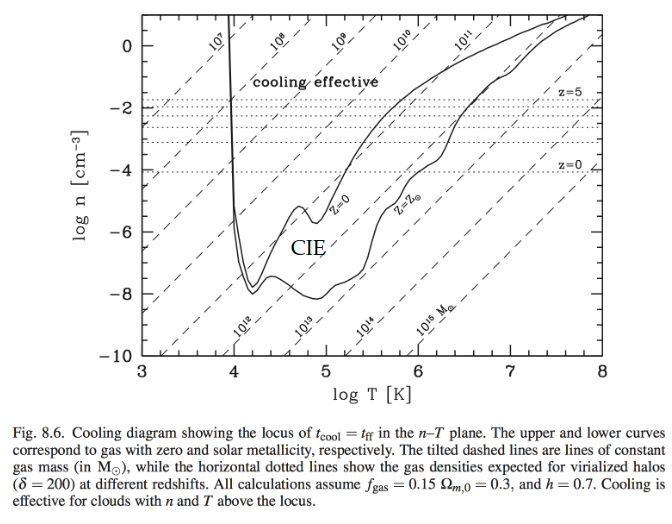

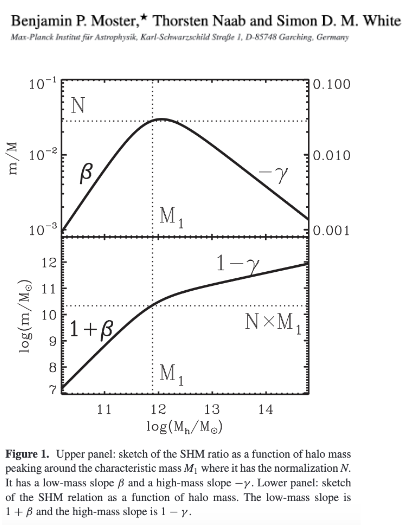


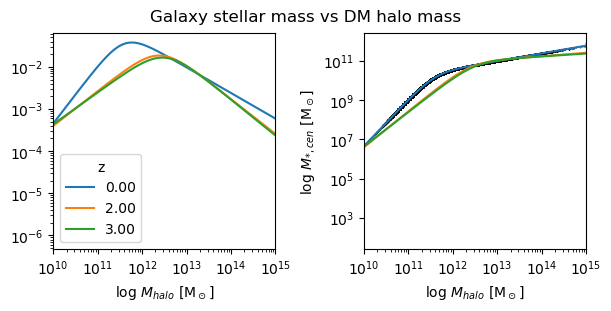

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(6,3),layout="constrained") 
fig.suptitle("Galaxy stellar mass vs DM halo mass") #fontsize=12

z = np.array([0,2,3])
M1_z = 10**(11.590+1.195*z/(z+1))
N_z = 0.0351-0.0247*z/(z+1)
beta_z = 1.376-0.826*z/(z+1) 
gamma_z = 0.608+0.329*z/(z+1)

M_halo = np.linspace(8,15,500) #log
m = np.log10(10**M_halo *2*N_z[0]*((10**M_halo/M1_z[0])**-beta_z[0]+(10**M_halo/M1_z[0])**gamma_z[0])**-1)

M_halo_data = []
for i in range(len(stellar_mass_bayes)):
    j = np.digitize(np.log10(stellar_mass_bayes[i]),m)-1
    M_halo_data.append(10**M_halo[j])
M_halo_data = np.array(M_halo_data)

for i in range(len(z)):
    axes[0].plot(10**M_halo,2*N_z[i]*((10**M_halo/M1_z[i])**-beta_z[i]+(10**M_halo/M1_z[i])**gamma_z[i])**-1, label="%.2f"%(z[i]))

#axes[0].scatter(M_halo_data,stellar_mass_bayes,s=0.1,c='black')
axes[0].set_xlim(1.e10,1.e15)
axes[0].set_xscale("log") ; axes[0].set_yscale("log")
axes[0].set_xlabel("log $M_{halo}$ [M$_\odot$]") ; axes[1].set_ylabel("log $M_{*,cen}/M_{halo}$") 
axes[0].legend(title="z")

for i in range(len(z)):
    axes[1].plot(10**M_halo,10**M_halo*2*N_z[i]*((10**M_halo/M1_z[i])**-beta_z[i]+(10**M_halo/M1_z[i])**gamma_z[i])**-1, label="%.2f"%(z[i]))

axes[1].scatter(M_halo_data,stellar_mass_bayes,s=0.1,c='black')

axes[1].set_xlim(1.e10,1.e15)
axes[1].set_xscale("log") ; axes[1].set_yscale("log")
axes[1].set_xlabel("log $M_{halo}$ [M$_\odot$]") ; axes[1].set_ylabel("log $M_{*,cen}$ [M$_\odot$]") 
plt.show()


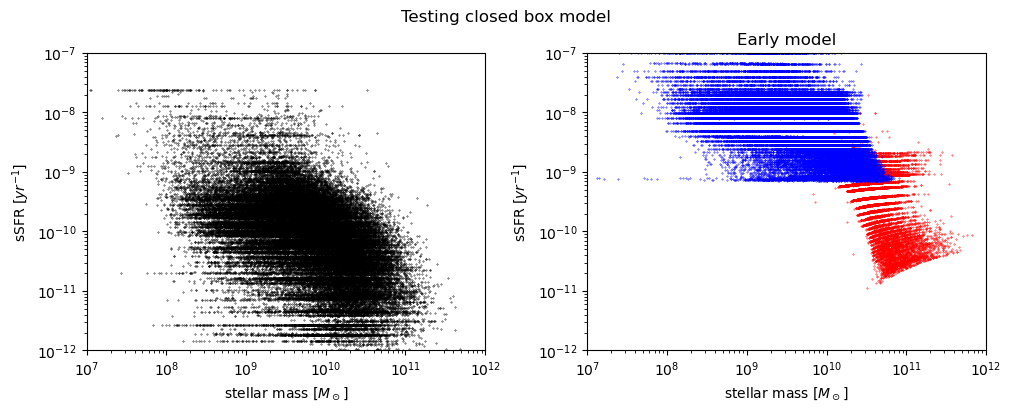

In [221]:
#model sSFR
predicted_sSFR = []
for i in range(len(stellar_mass_best)):
    if M_halo_data[i]<10**9 or M_halo_data[i]>10**12: #early model: closed box
        R_eff = A_early*(stellar_mass_best[i]/(5*10**10))**alpha_early #Kpc
        t_dyn = (2*np.pi*R_eff*3.086*10**16/v_circ[i])/(3.1536*10**13) #Myrs
        eps_p = 0.02/t_dyn
        predicted_sSFR.append(eps_p* 10**-6 * np.exp(-(eps_p*age[i]))/(1-np.exp(-(eps_p*age[i])))) #yrs-1
    else: #late model. Open box 
        R_eff = A_late*(stellar_mass_best[i]/(5*10**10))**alpha_late #Kpc
        t_dyn = (2*np.pi*R_eff*3.086*10**16/v_circ[i])/(3.1536*10**13) #Myrs
        eps_p = 0.02/t_dyn
        t = age[i]/10
        predicted_sSFR.append(eps_p* 10**-6 * np.exp(-eps_p*t)/(1-np.exp(-eps_p*t)))  #yrs-1
predicted_sSFR = np.array(predicted_sSFR)

fig, axes = plt.subplots(1, 2, figsize=(10,4),layout="constrained") 
fig.suptitle('Testing closed box model') #fontsize=12

axes[0].scatter(stellar_mass_best,sSFR_best, s=0.1, color='black')
axes[0].set_xscale('log') ; axes[0].set_yscale('log')
axes[0].set_xlim(10**7,10**12) ; axes[0].set_ylim(10**-12,10**-7)
axes[0].set_xlabel("stellar mass [$M_\odot$]") ; axes[0].set_ylabel("sSFR [$yr^{-1}$]") ; #axes[0,0].set_title("Bayes estimator")

#axes[1].scatter(stellar_mass_bayes[M_halo_data<10**9],predicted_sSFR[M_halo_data<10**9], s=0.1, color='red')
axes[1].scatter(stellar_mass_best[M_halo_data>10**12],predicted_sSFR[M_halo_data>10**12], s=0.1, color='red')
axes[1].scatter(stellar_mass_best[M_halo_data<10**12],predicted_sSFR[M_halo_data<10**12], s=0.1, color='blue')
axes[1].set_xscale('log') ; axes[1].set_yscale('log')
axes[1].set_xlim(10**7,10**12) ; axes[1].set_ylim(10**-12,10**-7)
axes[1].set_xlabel("stellar mass [$M_\odot$]") ; axes[1].set_ylabel("sSFR [$yr^{-1}$]") ; axes[1].set_title("Early model")
plt.show()



**OPEN-BOX MODEL**

$$\frac{dm_{gas}}{dt}(t)=\dot{m}_{gas}^{in}(t,,)-\dot{m}_{gas}^{out}(t,,) -(1-R)\epsilon' m_{gas}(t) $$

-SNIa $\dot{m}^{out}(t,,)\propto\beta\int SFR(t) \propto \beta m_*$

-SNIIa $\dot{m}^{out}(t,,)=\eta SFR(t) $

-AGN $\dot{m}^{out}(t,,)\propto\gamma M_{BH} $

-RAM pressure $\dot{m}^{out}(t,,)\propto\rho_{env}v_{gal}^2$

Assumptions: the only important term is the one due to SN type II: 

$$\frac{dm_{gas}}{dt}(t)=\dot{m}_{gas}^{in}(t,,)-(1+\eta-R)\epsilon' m_{gas}(t)$$

If $\dot{m}_{gas}^{in}\ll (1+\eta-R)\epsilon' m_{gas}$: (A) we get the closed box solution. Gas mass drops exponentially and eventually (A) doesn't hold any more  

If $\dot{m}_{gas}^{in}\gg (1+\eta-R)\epsilon' m_{gas}$ (B) the gas mass will increase exponentially up to the point (B) doesn't hold any more  

Will reach equilibrium: $\frac{dm_{gas}}{dt}(t)=0$:     $m_{gas}^{eq}=\frac{\dot{m}_{in}}{{(1+\eta-R)}}$

$$sSFR^{eq}=\frac{\dot{m}_{in}}{m_*}\frac{1}{(1+\eta-R)}$$

$$SFR^{eq}=\dot{m}_{in}\frac{1}{(1+\eta-R)}$$

**Lilly et al**

Doesn't assume equilibrium condition $\frac{dM_{gas}}{dt}=0$. 

$rsSFR=(1-r)sSFR$. Instantaneus return, $R=0.4$.

$$rsSFR(M_*,t)=0.07\left(\frac{M_*}{10^{10.5}M_\odot} \right)^{-0.1}(1+z)^3 \text{Gyr}^{-1} \text{( z<2)}$$

$$=0.3\left(\frac{M_*}{10^{10.5}M_\odot} \right)^{-0.1}(1+z)^{5/3} \text{Gyr}^{-1} \text{(z>2)}$$

$$sMIR(DM)=0.027\left(\frac{M_{halo}}{10^{12}M_\odot} \right)^{0.15}(1+z+0.1(1+z)^{-1.25})^{2.5}$$

SFR is determined by the istantaneous mass of gas in the internal reservoir. 

$$SFR=\epsilon(M_*,t) M_{gas}$$

Defining $\mu = M_{gas}/M_*$, $\mu = \epsilon^{-1}sSFR$. The mass in the gas reservoir changes with time, and the star formation rate is regulated by the gas reservoir. For a more general Kennicut-Schmidt relation $SFR=\epsilon M_{gas}^\kappa$:

$$\mu = (\epsilon^{-1}\cdot sSFR)^{1/\kappa}\cdot M_*^{-(\kappa-1)/\kappa)}$$

$\Psi=\lambda SFR$ mass loss from the system (winds). 

$\Phi$ is the istantaneous mass inflow from the halo into the galaxy, and it's a fraction $f_{gal}$ of the baryonic mass inflow into the halo. Mass conservation: 

$$\Phi=(1-R+\lambda)SFR+\dot{M}_{gas}$$

$$\frac{d\mu}{dt}=-\frac{M_{gas}}{M_*^2}(1-R)SFR+\frac{1}{M_*}\frac{dM_{gas}}{dt}$$

$$\frac{dM_{gas}}{dt}=\left(\mu(1-R) + \epsilon^{-1} \frac{dln\mu}{dt}\right)SFR$$

$$\Phi=\left((1-R)(1+\mu) + \lambda + \epsilon^{-1} \frac{dln\mu}{dt}\right)SFR$$

**Metallicity of the gas reservoir that sustains the regulator**

$Z_0$ metallicity of the infalling gas. $m_Z$, $Z$ mass and fraction of metals in the gas reservoir. $y$ mass of metals returned to the interstellar medium per unit mass that is locked up in long-lived stars $(1-R)M_*$. 

$$\frac{dM_Z}{dt}=y(1-R)SFR-Z(1-R+\lambda)SFR+\Phi Z_0$$

eliminating $\Phi$:

$$\frac{dM_Z}{dt}=(y(1-R)-(Z-Z_0)(1-R+\lambda))SFR+Z_0\frac{dM_{gas}}{dt}$$

$M_Z = ZM_{gas}$, then: 

$$\frac{Z}{dt}=\frac{1}{M_{gas}}\left[(y(1-R)-(Z-Z_0)(1-R+\lambda))SFR-(Z-Z_0)\frac{dM_{gas}}{dt}\right]$$  

or:

$$\frac{dZ}{dt}=(y(1-R)-(Z-Z_0)(1-R+\lambda))\epsilon-(Z-Z_0)\frac{1}{M_{gas}}\frac{dM_{gas}}{dt}$$ 

The three terms in the denominator on the right-hand side of equations reflect the three “destinations” of metals as the incoming flow divides; i.e., long-lived stars, removal from the system in an outflow, and the buildup of the gas reservoir.

An attractive aspect of the regulator is thus that the metallicity
at any point in time is set by the current state of the system
and not by the past history of it, provided that the dln μ/dt
term is small (see also Koppen & Edmunds 1999). In other
words, the chemical “evolution” of the reservoir is more the
changing (and reversible) operation of the regulator than a
monotonically-increasing temporal development of metallicity
due to the buildup of metals. We will henceforth drop the
equilibrium suffix on Zeq.

Metallicities in star-forming galaxies at earlier epochs
will be lower because the sSFRs in stellar systems are generally
higher.




**Dekel & Birnboim**
Once the halo gas is shock heated in massive haloes, what is the
process that keeps it hot and maintains the shutdown required by
the bimodality? 

supernova feedback: weakly dependent on gas fraction, density or metallicity, therefore insensitive to redshift

UV on dust feedback 

Photoionization feedback

AGN feedback

**Davé, Finlator, Oppenheimer model**

equilibrium condition:
$$\dot{M}_{in}=\dot{M}_{grav}-\dot{M}_{prev}+\dot{M}_{recyc}$$

mass loading factor $\eta=\dot{M}_{in}/\dot{M}_*$:
$$SFR = \dot{M}_{in}/(1+\eta)$$ 

cosmology by DEkel et al. (2009)
$$\frac{\dot{M}_{grav}}{M_{halo}}=0.47f_bM_{halo,12}^{0.15}\left(\frac{1+z}{3}\right)^{2.25} \text{Gyr}^{-1}$$

different parametrizations:
$$\dot{M}_{grav}=25.3M_{halo}^{0.1}(1+65z)\sqrt{\Omega_m(1+z)^3+\Omega_\Lambda} M_\odot\text{yr}^{-1}$$


preventive feedback parameter $\zeta$: the amount of gas that accretes to the central forming galaxy.

$\dot{M}_{recyc}$: gas infalling that has previously been ejected in outflows.

$$\dot{M}_{in}=\zeta\dot{M}_{grav}+\dot{M}_{recyc}$$

$\dot{M}_{grav}$ driven by gravity and independent on feedback processes. 

$\zeta_{photo}$: suppression of inflow owing to photoionization heating. OPerates at low masses and approaches zero below a photosuppression mass $M_\gamma\approx 10^8 - 10^9 M_\odot$

$\zeta_{quench}$: suppresses star formation in massive haloes. feedback from supermassive black holes. Drops to zero above the quenching mass $M_q\approx 10^{12} M_\odot$.

$\zeta_{grav}$ suppression of inflow by ambient gas heating due to virial shocks. (neglecting metal line cooling):

$$\zeta_{grav}\approx0.47\left(\frac{1+z}{4}\right)^{0.38}M_{halo,12}^{-0.25}$$

$\zeta_{winds}$ associated with additional heating of surrounding gas provided by energetic inputs from winds. It's a preventive feedback parameter, while $\eta$ ejective feedback. 

$$SFR= \frac{\zeta\dot{M}_{grav}}{(1+\eta)(1-\alpha_Z)}$$

Galaxies will tend to lie around these
relations owing to a balance of inflow, outflow and star formation.
The equilibrium relations depend on three parameters: η, ζ and
α Z , representing ejective feedback (i.e. outflows), preventive feed-
back and wind recycling. Additionally, the star formation law gov-
erns tdep , ˙Mgrav is set by cosmology, and y is set by nucleosynthetic
processes. Assuming those are well established, the mass and red-
shift (and possibly environmental) dependence of η, ζ and αZ gov-
ern the evolution of the global SFR, fgas and ZISM of galaxies. Note
that since the mass and redshift dependence of these parameters
are not fully known, the actual number of free parameters can be
significantly larger than three.

In [4]:
def zeta_photo(M_halo,z):
    M_gamma = np.where(z<2,3.e9,1.e9) 
    #M_gamma = 3.e9 if z<2 else 1.e9
    return (1+(1/3)*(M_halo/M_gamma)**-2)**-1.5
    
def zeta_quench(M_halo,z):
    M_quench = np.where(z<2, 10**12.3,1.e13)
    return (1+(M_halo/M_quench)**2)**-1.5 #??

def zeta_grav(M_halo,z):
    x = 0.47*((1+z)/4)**0.38 * (M_halo/10**12)**-0.25
    return np.where(x<1, x, 1)

def zeta_wind(M_halo,z): 
    M_winds = np.where(z<2,1.e11,1.e10) #1.e11 #if z<2 else 1.e1
    return (1+(1/3)*(M_halo/M_winds)**-2)**-0.2

def zeta(M_halo,z):
    return zeta_photo(M_halo,z)*zeta_quench(M_halo,z)*zeta_grav(M_halo,z)*zeta_wind(M_halo,z)

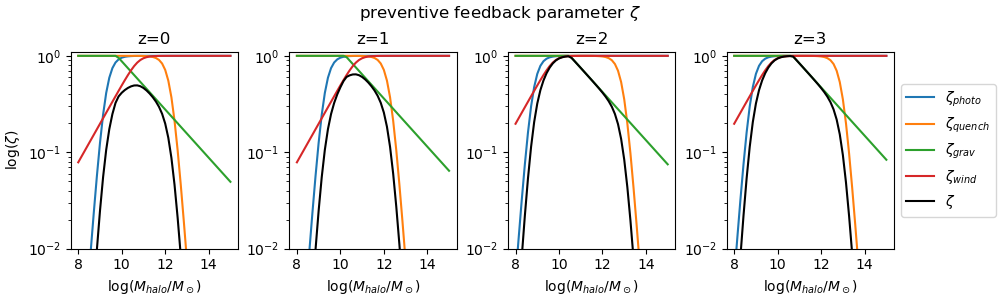

In [5]:
%matplotlib widget
fig, axes = plt.subplots(1, 4, figsize=(10,3),layout="constrained") 
fig.suptitle('preventive feedback parameter $\zeta$') #fontsize=12

M_halo = np.linspace(8,15)
z_dave = [0,1,2,3]

for i in range(4):
    axes[i].plot(M_halo,zeta_photo(10**M_halo,z_dave[i]),label="$\zeta_{photo}$")
    axes[i].plot(M_halo,zeta_quench(10**M_halo,z_dave[i]),label="$\zeta_{quench}$")
    axes[i].plot(M_halo,zeta_grav(10**M_halo,z_dave[i]),label="$\zeta_{grav}$")
    axes[i].plot(M_halo,zeta_wind(10**M_halo,z_dave[i]),label="$\zeta_{wind}$")
    axes[i].plot(M_halo,zeta(10**M_halo,z_dave[i]),label="$\zeta$",c='black')
    
axes[0].set_ylabel("log($\zeta$)")
for i in range(4):
    axes[i].set_yscale('log') ; axes[i].set_yscale('log')
    axes[i].set_ylim(10**-2,1.1)
    axes[i].set_xlabel("log($M_{halo}/M_\odot$)") 
    axes[i].set_title("z=%i" %z_dave[i]) 
    
axes[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

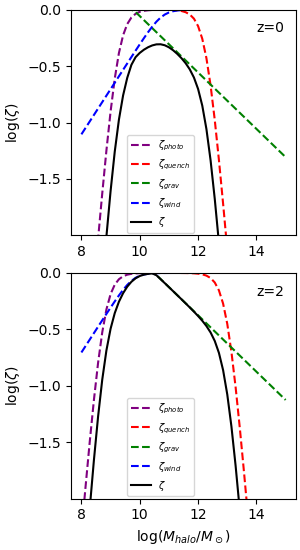

In [12]:
%matplotlib widget
fig, axes = plt.subplots(2, 1, figsize=(3,5.5),layout="constrained") 

M_halo = np.linspace(8,15)
z_dave = [0,2]

for i in range(2):
    axes[i].plot(M_halo,np.log10(zeta_photo(10**M_halo,z_dave[i])),label="$\zeta_{photo}$",c='purple',linestyle='--')
    axes[i].plot(M_halo,np.log10(zeta_quench(10**M_halo,z_dave[i])),label="$\zeta_{quench}$",c='red',linestyle='--')
    axes[i].plot(M_halo,np.log10(zeta_grav(10**M_halo,z_dave[i])),label="$\zeta_{grav}$",c='green',linestyle='--')
    axes[i].plot(M_halo,np.log10(zeta_wind(10**M_halo,z_dave[i])),label="$\zeta_{wind}$",c='blue',linestyle='--')
    axes[i].plot(M_halo,np.log10(zeta(10**M_halo,z_dave[i])),label="$\zeta$",c='black')
    

for i in range(2):
    axes[i].set_yticks([0,-0.5,-1,-1.5])
    axes[i].set_ylabel("log($\zeta$)")
    axes[i].set_ylim(-2,0)
    axes[i].text(14,-0.2,"z=%i" %z_dave[i]) 

axes[1].set_xlabel("log($M_{halo}/M_\odot$)") 
    
#axes[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].legend(loc=(0.25, 0.01), prop={'size': 7}) 
axes[1].legend(loc=(0.25, 0.01), prop={'size': 7}) #bbox_to_anchor=(10,0)
plt.show()

In [9]:
#converts redshift in time
def redshift_to_time(z):
    Ho = 70 #1/s 
    Om = 0.3
    Ol = 0.7
    return 13 - 0.98*1.e3 * quad(lambda x: 1/(Ho * np.sqrt(Om * (1 + x)**5 + Ol * (1 + x)**(2))), a=0, b=z)[0] #Gyr

#converts time to redshift
def time_to_redshift(t):
    return z_at_value(Planck13.age, t*u.Gyr) 

redshift_ticks = [0,1,2,3,4,5]
age_ticks = []
for z_tick in redshift_ticks:
    age_ticks.append(redshift_to_time(z_tick))

t_obs_3DHST = []
for z_3dhst in redshift_3DHST:
    t_obs_3DHST.append(redshift_to_time(z_3dhst)) #Gyrs #13-
t_obs_3DHST = np.array(t_obs_3DHST)


In [63]:
#SIMPLE OPEN BOX MODEL

eps = 0.02 
eta = 1. 
R = 0.4 
Z0 = 0
y = 0.016

f_b = 0.15
redshift_bins = [0,0.75,1.5,2.5,3]

M_h_form = 5.e8 # dm halo mass at t_form #5.e8

#M_h_max = M_shock if z[i] < 1.3 else M_shock**2/(1.3*10**(13.1-1.3*z[i])) #cold accretion in hot halo

def evolve_galaxy(t_form, t_obs, M_h_in, M_h_min, M_h_max): 
    M_h = t*0 ; M_g = t*0 ; M_s = t*0 ; SFR = t*0 ; sSFR = t*0 ; Z = t*0
    i = 0
    for i in range(len(t)):
        if t[i]<t_form : 
            M_h[i] = M_h_in
        elif t[i]<t_obs:
            
            #M_dot_h = 42.0*((M_h[i-1]/1.e12)**1.127)*(1+1.17*z[i])*(0.3*(1+z[i])**3+0.7)**0.5 #M_sun/yr #different formula for M_dot_h
            M_dot_h = 510*((M_h[i-1]/1.e12)**1.1)*((1+z[i])/3.12)**2.2 #M_sun/yr #1.1
            
            M_h[i] = M_h[i-1]+M_dot_h*dt*1.e9
            
            t_dyn = 2.e7*((1+z[i])/3.2)**(-3/2)

            if M_h[i]<M_h_min: csi=0.0
            elif M_h[i]>M_h_min and M_h[i]<M_h_max: csi=1.0 
            else: csi = 0.0

            #csi = zeta(M_h[i],z[i])

            M_dot_g = f_b * csi * M_dot_h - (eps/t_dyn) * (1+eta-R) * M_g[i-1] #M_sun/yr
            M_g[i] = M_g[i-1]+ dt*1.e9*M_dot_g
            SFR[i] = eps*M_g[i]/t_dyn
            M_s[i] = M_s[i-1]+ SFR[i]*dt*1.e9
            sSFR[i] = SFR[i]/M_s[i]
            Z_dot = (y*(1-R)-(Z[i-1]-Z0)*(1-R+eta))*(eps/t_dyn) - (Z[i-1]-Z0) * M_dot_g/M_g[i-1] if M_g[i-1] > 0 else 0
            Z[i] = (Z[i-1] + dt*1.e9*Z_dot)
        else:
            M_h[i] = M_h[i-1]
            M_g[i] = M_g[i-1]
            M_s[i] = M_s[i-1]
            SFR[i] = SFR[i-1]
            sSFR[i] = sSFR[i-1]
            Z[i] = Z[i-1]
    Z = np.log10(Z/0.02) + 8.69
    return M_h, M_g, M_s, SFR, sSFR, Z

/tmp/ipykernel_2933/3903923085.py:41: RuntimeWarning: invalid value encountered in scalar divide
  sSFR[i] = SFR[i]/M_s[i]
/tmp/ipykernel_2933/3903923085.py:51: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(Z/0.02) + 8.69
/tmp/ipykernel_2933/1411663188.py:60: RuntimeWarning: invalid value encountered in divide
  f_g = M_g/(M_g+M_s)
/tmp/ipykernel_2933/1411663188.py:77: RuntimeWarning: divide by zero encountered in log10
  axes2[0].scatter(np.log10(M_s[k]),np.log10(SFR[k]),c=col_plot[i])
/tmp/ipykernel_2933/1411663188.py:78: RuntimeWarning: divide by zero encountered in log10
  axes2[1].scatter(np.log10(M_s[k]),np.log10(sSFR[k]),c=col_plot[i])
/tmp/ipykernel_2933/3903923085.py:25: RuntimeWarning: overflow encountered in scalar power
  M_dot_h = 510*((M_h[i-1]/1.e12)**1.1)*((1+z[i])/3.12)**2.2 #M_sun/yr #1.1
/tmp/ipykernel_2933/3903923085.py:37: RuntimeWarning: invalid value encountered in scalar multiply
  M_dot_g = f_b * csi * M_dot_h - (eps/t_dyn) * (1+eta-R) * M_

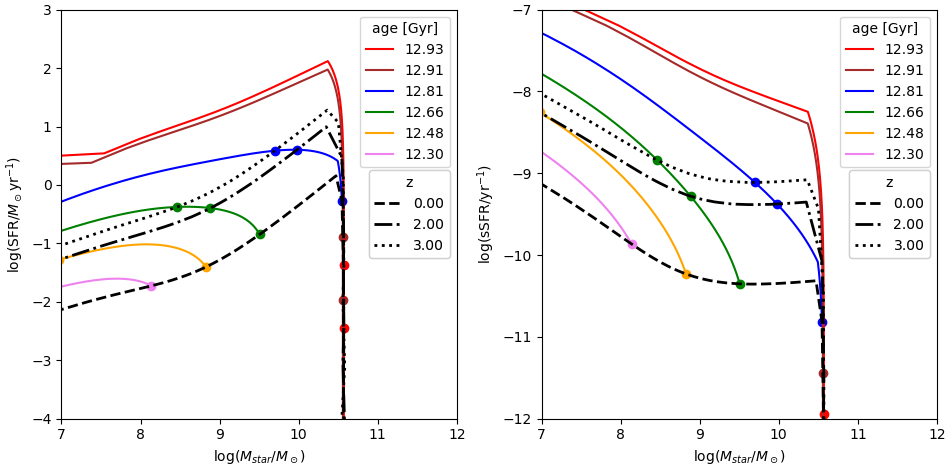

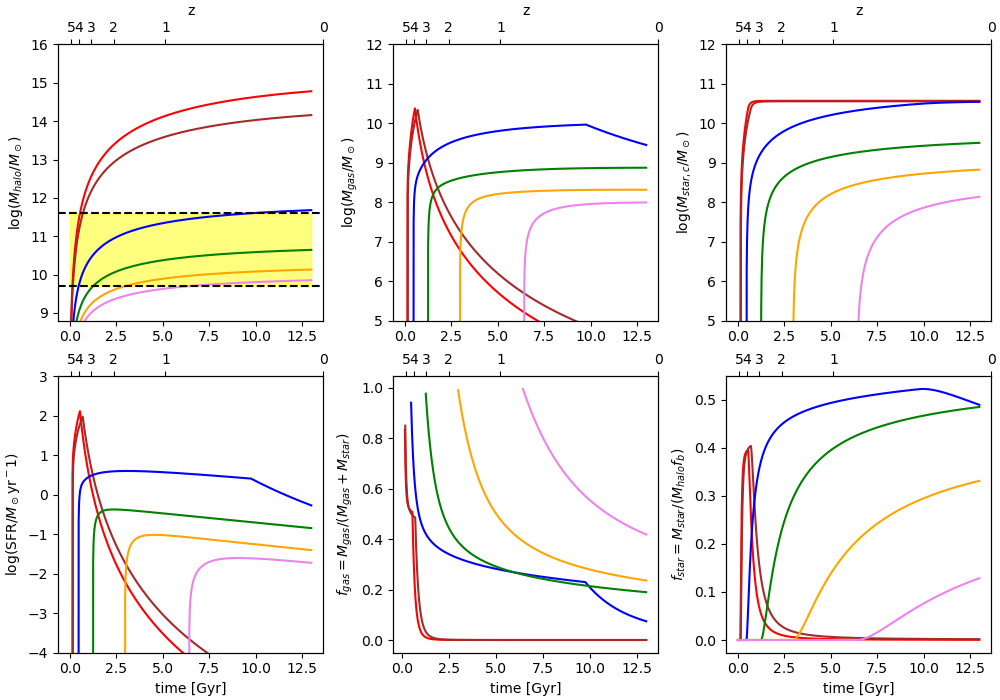

In [64]:
%matplotlib widget 
#%matplotlib inline
#set global arrays
dt=0.01 #Gyr
t = np.arange(dt,13.0,dt) #Gyr
z = t*0
for i in range(len(t)):
    z[i] = time_to_redshift(t[i])

fig, axes = plt.subplots(2,3, figsize=(10,7),layout="constrained") 
#fig.suptitle('Dark matter halo and galactic evolution, constant $M_{min}$ and $M_{max}$, $\zeta=0,1$') #fontsize=12

axes[0,0].set_ylabel("log($M_{halo}/M_\odot$)")
axes[0,1].set_ylabel("log($M_{gas}/M_\odot$)")
axes[0,2].set_ylabel("log($M_{star,c}/M_\odot$)")
axes[1,0].set_ylabel("log(SFR/$M_\odot$yr$^-1$)")
axes[1,1].set_ylabel("$f_{gas}=M_{gas}/(M_{gas}+M_{star})$")
#axes[1,2].set_ylabel("12+log(O/H)")   
axes[1,2].set_ylabel("$f_{star}=M_{star}/(M_{halo}f_b)$")

for i in range(3):
    axes[1,i].set_xlabel("time [Gyr]") 
    axes[0,i].twiny().set(xticks=age_ticks,xticklabels=['{:g}'.format(z_tick) for z_tick in redshift_ticks],xlabel="z")
    axes[1,i].twiny().set(xticks=age_ticks,xticklabels=['{:g}'.format(z_tick) for z_tick in redshift_ticks])

#secay = axes[1,2].secondary_yaxis('right', functions=(lambda y:0.02*10**(y-8.69), lambda y:np.log10(y/0.02)+8.69))
#secay.set_ylabel('metals fraction Z')
#secay.set_yscale("log")

fig2, axes2 = plt.subplots(1, 2, figsize=(9.5,4.7),layout="constrained") 
#fig2.suptitle('SFR and sSFR evolution, constant $M_{min}$ and $M_{max}$, $\zeta=0,1$') #fontsize=12
axes2[0].set_xlabel("log($M_{star}/M_\odot$)") ; axes2[1].set_xlabel("log($M_{star}/M_\odot$)") ; #axes2[2].set_xlabel("log($M_{star}/M_\odot$)")
axes2[0].set_ylabel("log(SFR/$M_\odot$yr$^{-1}$)")
axes2[1].set_ylabel("log(sSFR/yr$^{-1}$)")
#axes2[2].set_ylabel("12+log(O/H)")

#secay2 = axes2[2].secondary_yaxis('right', functions=(lambda y:0.02*10**(y-8.69), lambda y:np.log10(y/0.02)+8.69))
#secay2.set_ylabel('metals fraction Z')
#secay2.set_yscale("log")

axes[0,0].set_ylim(8.8,16)
axes[0,1].set_ylim(5,12)
axes[0,2].set_ylim(5,12)
axes[1,0].set_ylim(-4,3)

axes2[0].set_xlim(7,12) ; axes2[1].set_xlim(7,12) ;# axes2[2].set_xlim(7,13)
axes2[0].set_ylim(-4,3)
axes2[1].set_ylim(-12,-7)


###############################################################################################################################

t_form_plot = [0.07,0.09,0.19,0.34,0.52,0.7] #,0.16
col_plot = ["red","brown","blue","green","orange","violet"]
plots1 = []

redshift_bins = [0,2,3]
for i in range(len(t_form_plot)):
    M_h, M_g, M_s, SFR, sSFR, Z = evolve_galaxy(t_form=t_form_plot[i],t_obs=13,M_h_in=M_h_form,M_h_min=5.e9,M_h_max=10**11.6) 
    f_g = M_g/(M_g+M_s)
    f_s = M_s/(M_h*f_b)
    axes[0,0].plot(t,np.log10(np.where(M_h>0,M_h,1)),c=col_plot[i])
    axes[0,1].plot(t,np.log10(np.where(M_g>0,M_g,1)),c=col_plot[i])
    axes[0,2].plot(t,np.log10(np.where(M_s>0,M_s,1)),c=col_plot[i])
    axes[1,0].plot(t,np.log10(np.where(SFR>0,SFR,1.e-16)),c=col_plot[i])
    axes[1,1].plot(t,f_g,c=col_plot[i]) 
    axes[1,2].plot(t,f_s,c=col_plot[i])    
    #axes[1,2].plot(t,np.where(Z>0,Z,Z0),c=col_plot[i])  
    
    pl1, = axes2[0].plot(np.log10(np.where(M_s>0,M_s,1.0)),np.log10(np.where(SFR>0,SFR,1.0)),c=col_plot[i],label="%.2f"%(13-t_form_plot[i])) #np.where(M_s>0,M_s,1.0)
    plots1.append(pl1)
    axes2[1].plot(np.log10(np.where(M_s>0,M_s,1.0)),np.log10(np.where(sSFR>0,sSFR,1.0)),c=col_plot[i])
    #axes2[2].plot(np.log10(np.where(M_s>0,M_s,1.0)),np.where(Z>0,Z,Z0),c=col_plot[i])

    for r in range(len(redshift_bins)):
        k = np.digitize(redshift_bins[r],z)-1
        axes2[0].scatter(np.log10(M_s[k]),np.log10(SFR[k]),c=col_plot[i])
        axes2[1].scatter(np.log10(M_s[k]),np.log10(sSFR[k]),c=col_plot[i])

M_h_min = 5.e9
M_shock = 10**11.6    
#def M_h_max(z):
#    return np.where(z<1.3,M_shock,M_shock**2/(1.3*10**(13.1-1.3*z)))
    
axes[0,0].axhline(y=np.log10(M_h_min),c='black',linestyle='--')
axes[0,0].axhline(y=np.log10(M_shock),c='black',linestyle='--')
#axes[0,0].plot(t,np.log10(M_h_max(z)),c='black',linestyle='--')
axes[0,0].fill_between(t,np.log10(M_h_min),np.log10(M_shock), color='yellow',alpha=0.5)
#axes[0,0].fill_between(t,np.log10(M_shock),np.log10(M_h_max(z)), color='red',alpha=0.5)


#################################################################

redshift_bins = [0,2,3]
t_form_plot = np.linspace(0.02,1.5,100) #determines initial halo mass
plots_SFR = [] ; plots_sSFR = [] ; plots_Z = []
for i in range(len(redshift_bins)):
    M_s_z = [] ; SFR_z = [] ; sSFR_z = [] ; Z_z = []
    for j in range(len(t_form_plot)):
        k = np.digitize(redshift_bins[i],z)-1
        M_h, M_g, M_s, SFR, sSFR, Z = evolve_galaxy(t_form=t_form_plot[j],t_obs=13,M_h_in=M_h_form,M_h_min=5.e9,M_h_max=10**11.6) 
        M_s_z.append(M_s[k])
        SFR_z.append(SFR[k])
        sSFR_z.append(sSFR[k])
        Z_z.append(Z[k])
    plots_SFR.append([M_s_z,SFR_z])
    plots_sSFR.append([M_s_z,sSFR_z])
    plots_Z.append([M_s_z,Z_z])
plots_SFR = np.array(plots_SFR) ; plots_sSFR = np.array(plots_sSFR) ; plots_Z = np.array(plots_Z)

linestyle_arr = ['--','-.',':']
plots2 = []
for i in range(len(redshift_bins)):
    pl2, = axes2[0].plot(np.log10(plots_SFR[i,0]),np.log10(plots_SFR[i,1]),c='black',linestyle=linestyle_arr[i],linewidth=2,label="%.2f"%redshift_bins[i]) #,linestyle=linestyle_arr[i]
    plots2.append(pl2)
    axes2[1].plot(np.log10(plots_sSFR[i,0]),np.log10(plots_sSFR[i,1]),c='black',linestyle=linestyle_arr[i],linewidth=2,label="%.2f"%redshift_bins[i]) #linestyle='--'
    #axes2[2].plot(np.log10(plots_Z[i,0]),plots_Z[i,1],c='black',linestyle=linestyle_arr[i],linewidth=1,label="%.2f"%redshift_bins[i])

#legends
leg1 = axes2[0].legend(handles=plots1, loc="upper right",title="age [Gyr]") 
axes2[0].add_artist(leg1)
leg2 = axes2[0].legend(handles=plots2, loc="center right", title="z") 
axes2[0].add_artist(leg2)

#legends
leg1 = axes2[1].legend(handles=plots1, loc="upper right",title="age [Gyr]") 
axes2[1].add_artist(leg1)
leg2 = axes2[1].legend(handles=plots2, loc="center right", title="z") 
axes2[1].add_artist(leg2)

plt.show()

In [54]:
#SDSS z = 0

#devides sperimental points in bins, computes statistical quantities

n_bins = 15
bins_m = np.logspace(8,11,n_bins)
SFR_MS_bins = [ [] for _ in range(n_bins)]
sSFR_MS_bins = [ [] for _ in range(n_bins)]

for i in range(len(stellar_mass_best)): 
    j = np.digitize(stellar_mass_best[i],bins_m)-1
    #if sSFR_best[i] > 1.e-12 #M_halo_data[i] < M_crit(0): 
    SFR_MS_bins[j].append(np.log10(SFR_best[i])) 
    sSFR_MS_bins[j].append(np.log10(sSFR_best[i])) 

#statistics: we take medians as means and half the difference between 86th and 16th percentile
#much less subject to outliars than mean and median

SFR_MS_medians = [] ; sSFR_MS_medians = [] ; SFR_MS_disp = [] ; sSFR_MS_disp = []

for i in range(n_bins): 
    median_SFR = np.median(SFR_MS_bins[i])
    median_sSFR = np.median(np.median(sSFR_MS_bins[i]))
    SFR_MS_medians.append(median_SFR)
    sSFR_MS_medians.append(median_sSFR)
    if len(SFR_MS_bins[i]) > 1: 
        SFR_MS_disp.append((np.percentile(SFR_MS_bins[i],86)-np.percentile(SFR_MS_bins[i],16))/2)
    else:
        SFR_MS_disp.append(0)
    if len(sSFR_MS_bins[i]) > 1: 
        sSFR_MS_disp.append((np.percentile(sSFR_MS_bins[i],86)-np.percentile(sSFR_MS_bins[i],16))/2)
    else:
        sSFR_MS_disp.append(0)


In [24]:
#DETERMINES BETTER MODEL. Which M_min, M_max minimizes Chi squared? NOT DAVE

m_h_min_chi = np.logspace(9,11,10)
m_h_max_chi = np.logspace(11,13,10) 

CHI2_TEST = []

for m_h_min in m_h_min_chi:
    for m_h_max in m_h_max_chi:
        if m_h_max > m_h_min: 
    
            sum_residuals_SFR = 0
            
            M_s_today = [] ; SFR_today = [] ; sSFR_today = [] ; Z_today = []
            for i in range(len(t_formation_plot)):
                M_h, M_g, M_s, SFR, sSFR, Z = evolve_galaxy(t_form=t_form_plot[i],t_obs=13,M_h_in=M_h_form, M_h_min=m_h_min,M_h_max=m_h_max)
                if M_s[-1] > 1.e8 and M_s[-1]<1.e18:
                    M_s_today.append(M_s[-1])
                    SFR_today.append(SFR[-1])
                    sSFR_today.append(sSFR[-1])
                    Z_today.append(Z[-1])
            M_s_today = np.array(M_s_today) ; SFR_today = np.array(SFR_today) ; sSFR_today = np.array(sSFR_today) ; Z_today = np.array(Z_today)

            
            for i in range(n_bins): 
                M_s_today.sort()
                j = np.digitize(bins_m[i],M_s_today)-1 
                if SFR_today[j]>-1.e-999:
                    sum_residuals_SFR = sum_residuals_SFR + (SFR_MS_medians[i]-np.log10(SFR_today[j]))**2/SFR_MS_disp[i]**2
            print("%f , %f , %f" %(np.log10(m_h_min),np.log10(m_h_max),sum_residuals_SFR/(n_bins-2)))
            CHI2_TEST.append([np.log10(m_h_min),np.log10(m_h_max),sum_residuals_SFR/(n_bins-2)])

#CHI2_TEST_ = np.array(CHI2_TEST)
#print(min(CHI2_TEST_[:,2]))
#j = CHI2_TEST[2][:].index(min(CHI2_TEST_[:,2]))
#print(CHI2_TEST[j])

    

/tmp/ipykernel_53086/252273115.py:39: RuntimeWarning: invalid value encountered in scalar divide
  sSFR[i] = SFR[i]/M_s[i]
/tmp/ipykernel_53086/252273115.py:49: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(Z/0.02) + 8.69
/tmp/ipykernel_53086/252273115.py:25: RuntimeWarning: overflow encountered in scalar power
  M_dot_h = 510*((M_h[i-1]/1.e12)**1.1)*((1+z[i])/3.12)**2.2 #M_sun/yr
/tmp/ipykernel_53086/252273115.py:35: RuntimeWarning: invalid value encountered in scalar multiply
  M_dot_g = f_b * csi * M_dot_h - (eps/t_dyn) * (1+eta-R) * M_g[i-1] #M_sun/yr
/tmp/ipykernel_53086/252273115.py:49: RuntimeWarning: invalid value encountered in log10
  Z = np.log10(Z/0.02) + 8.69


9.000000 , 11.000000 , 48.039913
9.000000 , 11.222222 , 47.840704
9.000000 , 11.444444 , 47.682328
9.000000 , 11.666667 , 47.457653
9.000000 , 11.888889 , 47.385097
9.000000 , 12.111111 , 47.234763
9.000000 , 12.333333 , 47.057574
9.000000 , 12.555556 , 46.766663
9.000000 , 12.777778 , 46.766663
9.000000 , 13.000000 , 46.766663
9.222222 , 11.000000 , 43.221367
9.222222 , 11.222222 , 42.945313
9.222222 , 11.444444 , 42.726359


KeyboardInterrupt: 

In [55]:
#chi2 test for Dave z=0

sum_residuals_SFR = 0
            
M_s_today = [] ; SFR_today = [] ; sSFR_today = [] ; Z_today = []
for i in range(len(t_form_plot)):
    M_h, M_g, M_s, SFR, sSFR, Z = evolve_galaxy(t_form=t_form_plot[i],t_obs=13,M_h_in=M_h_form)
    if M_s[-1] > 1.e8 and M_s[-1]<1.e18:
        M_s_today.append(M_s[-1])
        SFR_today.append(SFR[-1])
        sSFR_today.append(sSFR[-1])
        Z_today.append(Z[-1])
M_s_today = np.array(M_s_today) ; SFR_today = np.array(SFR_today) ; sSFR_today = np.array(sSFR_today) ; Z_today = np.array(Z_today)

for i in range(n_bins): 
    M_s_today.sort()
    j = np.digitize(bins_m[i],M_s_today)-1 
    if SFR_today[j]>-1.e-999:
            sum_residuals_SFR = sum_residuals_SFR + (SFR_MS_medians[i]-np.log10(SFR_today[j]))**2/SFR_MS_disp[i]**2
print("%f" %(sum_residuals_SFR/(n_bins-2)))



TypeError: evolve_galaxy() missing 2 required positional arguments: 'M_h_min' and 'M_h_max'

/tmp/ipykernel_2933/3903923085.py:41: RuntimeWarning: invalid value encountered in scalar divide
  sSFR[i] = SFR[i]/M_s[i]
/tmp/ipykernel_2933/3903923085.py:51: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(Z/0.02) + 8.69
/tmp/ipykernel_2933/3903923085.py:25: RuntimeWarning: overflow encountered in scalar power
  M_dot_h = 510*((M_h[i-1]/1.e12)**1.1)*((1+z[i])/3.12)**2.2 #M_sun/yr #1.1
/tmp/ipykernel_2933/3903923085.py:37: RuntimeWarning: invalid value encountered in scalar multiply
  M_dot_g = f_b * csi * M_dot_h - (eps/t_dyn) * (1+eta-R) * M_g[i-1] #M_sun/yr


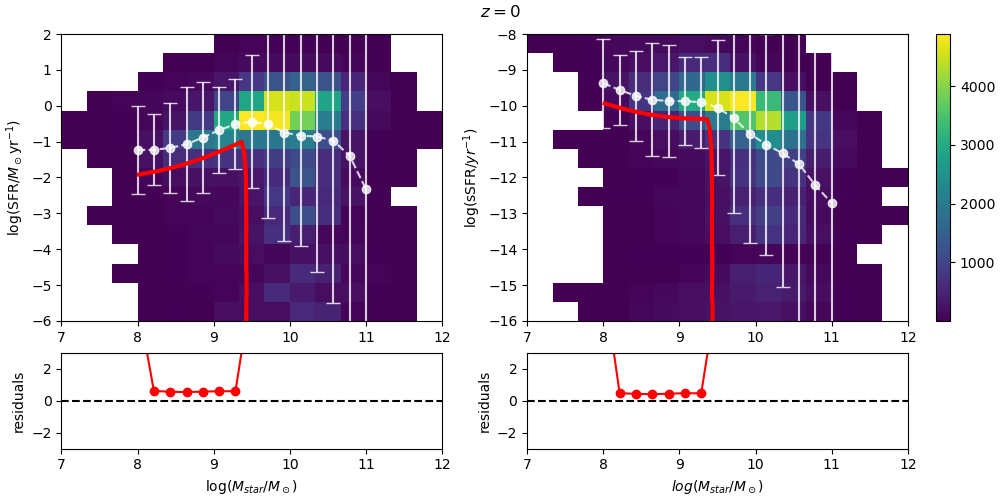

In [58]:
%matplotlib widget
t_form_plot = np.linspace(0.,1.5,100) #determines initial halo mass
M_h_form = 5.e8

M_s_today = [] ; SFR_today = [] ; sSFR_today = [] ; Z_today = []
for i in range(len(t_form_plot)):
    M_h, M_g, M_s, SFR, sSFR, Z = evolve_galaxy(t_form=t_form_plot[i],t_obs=13,M_h_in=M_h_form,M_h_min=10**9.5,M_h_max=10**10.5) 
    if M_s[-1] > 1.e8 and M_s[-1]<1.e11:
        M_s_today.append(M_s[-1])
        SFR_today.append(SFR[-1])
        sSFR_today.append(sSFR[-1])
        Z_today.append(Z[-1])
M_s_today = np.array(M_s_today) ; SFR_today = np.array(SFR_today) ; sSFR_today = np.array(sSFR_today) ; Z_today = np.array(Z_today)


residuals_SFR = [] ; residuals_sSFR = []
for i in range(n_bins): 
    M_s_today_ = M_s_today.copy() ; SFR_today_ = SFR_today.copy() ; sSFR_today_ = sSFR_today.copy()
    idx_order =  np.argsort(M_s_today_)
    M_s_today_ = M_s_today_[idx_order]
    SFR_today_ = SFR_today_[idx_order]
    sSFR_today_ = sSFR_today_[idx_order]
    j = np.digitize(bins_m[i],M_s_today_)-1 
    residuals_SFR.append(SFR_MS_medians[i]-np.log10(SFR_today_[j]))
    residuals_sSFR.append(sSFR_MS_medians[i]-np.log10(sSFR_today_[j]))
residuals_SFR = np.array(residuals_SFR) ; residuals_sSFR = np.array(residuals_sSFR)

#######################################################################################################################################

fig, axes = plt.subplots(2,2, figsize=(10,5),layout="constrained",gridspec_kw={'height_ratios': [3, 1]}) 
fig.suptitle('$z=0$') #fontsize=12

hist1 = axes[0,0].hist2d(np.log10(stellar_mass_best),np.log10(SFR_best), bins=[n_bins,n_bins], range=[[7, 12], [-6, 2]],cmin=1) #,SFR_best,bins = [bins_m,bins_sfr] n_bins,50], range=[[7, 12], [-12, 2]]
axes[0,0].errorbar(np.log10(bins_m), SFR_MS_medians, yerr = SFR_MS_disp, c='w',alpha=0.8,ls='--', marker='o', capsize=5, capthick=1) #yerr=MS_disp,
axes[1,0].plot(np.log10(bins_m),residuals_SFR,marker='o',c='r')
axes[1,0].axhline(y=0,linestyle='--',c='black')
axes[1,0].set_xlim(7,12)
axes[1,0].set_ylim(-3,3)

hist2 = axes[0,1].hist2d(np.log10(stellar_mass_best),np.log10(sSFR_best), bins=[n_bins,n_bins], range=[[7, 12], [-16,-8]],cmin=1)
#plt.colorbar(hist2[3], ax=axes[1], location="bottom",shrink=0.5)
axes[0,1].errorbar(np.log10(bins_m), sSFR_MS_medians, yerr = sSFR_MS_disp, c='w',alpha=0.8,ls='--', marker='o', capsize=5, capthick=1)
axes[1,1].plot(np.log10(bins_m),residuals_sSFR,marker='o',c='r')
axes[1,1].axhline(y=0,linestyle='--',c='black')
axes[1,1].set_xlim(7,12)
axes[1,1].set_ylim(-3,3)


axes[0,0].plot(np.log10(M_s_today),np.log10(SFR_today),c='red',linewidth=3)
axes[0,1].plot(np.log10(M_s_today),np.log10(sSFR_today),color='red',linewidth=3)


axes[1,0].set_xlabel("log($M_{star}/M_\odot$)") ; axes[1,1].set_xlabel("$log(M_{star}/M_\odot$)") ;
axes[0,0].set_ylabel("log(SFR/$M_\odot$yr$^{-1}$)") ; 
axes[0,1].set_ylabel("log(sSFR/$yr^{-1}$)") ; 

fig.colorbar(hist1[3],ax=axes[0,1], location="right",shrink=1.)

axes[1,0].set_ylabel("residuals")
axes[1,1].set_ylabel("residuals")

plt.show()



In [31]:
#3DHST z = 2

stellar_mass_3DHST_ = stellar_mass_3DHST[redshift_3DHST>2]
SFR_3DHST_ = SFR_3DHST[redshift_3DHST>2]
sSFR_3DHST_ = sSFR_3DHST[redshift_3DHST>2]
stellar_mass_3DHST_ = stellar_mass_3DHST[redshift_3DHST>2]

#devides sperimental points in bins, computes statistical quantities

n_bins = 15
bins_m = np.logspace(9,11.5,n_bins)
SFR_MS_bins = [ [] for _ in range(n_bins)]
sSFR_MS_bins = [ [] for _ in range(n_bins)]

for i in range(len(stellar_mass_3DHST_)): 
    j = np.digitize(stellar_mass_3DHST[i],bins_m)-1
    SFR_MS_bins[j].append(np.log10(SFR_3DHST_[i])) 
    sSFR_MS_bins[j].append(np.log10(sSFR_3DHST_[i])) 

#statistics: we take medians as means and half the difference between 86th and 16th percentile
#much less subject to outliars than mean and median

SFR_MS_medians = [] ; sSFR_MS_medians = [] ; SFR_MS_disp = [] ; sSFR_MS_disp = []

for i in range(n_bins): 
    median_SFR = np.median(SFR_MS_bins[i])
    median_sSFR = np.median(np.median(sSFR_MS_bins[i]))
    SFR_MS_medians.append(median_SFR)
    sSFR_MS_medians.append(median_sSFR)
    if len(SFR_MS_bins[i]) > 1: 
        SFR_MS_disp.append((np.percentile(SFR_MS_bins[i],86)-np.percentile(SFR_MS_bins[i],16))/2)
    else:
        SFR_MS_disp.append(0)
    if len(sSFR_MS_bins[i]) > 1: 
        sSFR_MS_disp.append((np.percentile(sSFR_MS_bins[i],86)-np.percentile(sSFR_MS_bins[i],16))/2)
    else:
        sSFR_MS_disp.append(0)


/tmp/ipykernel_2933/3415527915.py:17: RuntimeWarning: divide by zero encountered in log10
  SFR_MS_bins[j].append(np.log10(SFR_3DHST_[i]))
/tmp/ipykernel_2933/3415527915.py:18: RuntimeWarning: divide by zero encountered in log10
  sSFR_MS_bins[j].append(np.log10(sSFR_3DHST_[i]))


In [20]:
#DETERMINES BETTER MODEL. Which M_min, M_max minimizes Chi squared?

t_form_plot = np.linspace(0.,2.5,100) #determines initial halo mass
M_h_form = 5.e8
t_z_2 = redshift_to_time(2)

m_h_min_chi = np.logspace(9,11,10)
m_h_max_chi = np.logspace(11,15,10) 

t_formation_plot = np.linspace(0.1,5,100) #determines initial halo mass
M_h_form = 5.e8

CHI2_TEST = []

for m_h_min in m_h_min_chi:
    for m_h_max in m_h_max_chi:
        if m_h_max > m_h_min: 
    
            sum_residuals_SFR = 0
            
            M_s_today = [] ; SFR_today = [] ; sSFR_today = [] ; Z_today = []
            for i in range(len(t_form_plot)):
                M_h, M_g, M_s, SFR, sSFR, Z = evolve_galaxy(t_form=t_form_plot[i],t_obs=t_z_2,M_h_in=M_h_form, M_h_min=m_h_min,M_h_max=m_h_max)
                if M_s[-1] > 1.e8 and M_s[-1]<1.e16:
                    M_s_today.append(M_s[-1]) #_z_2
                    SFR_today.append(SFR[-1])
                    sSFR_today.append(sSFR[-1])
                    Z_today.append(Z[-1])
            M_s_today = np.array(M_s_today) ; SFR_today = np.array(SFR_today) ; sSFR_today = np.array(sSFR_today) ; Z_today = np.array(Z_today)

            
            for i in range(n_bins): 
                M_s_today.sort()
                j = np.digitize(bins_m[i],M_s_today)-1 
                #if SFR_today[j]>-1.e-999:
                sum_residuals_SFR = sum_residuals_SFR + (SFR_MS_medians[i]-np.log10(SFR_today[j]))**2/SFR_MS_disp[i]**2
            print("%f , %f , %f" %(np.log10(m_h_min),np.log10(m_h_max),sum_residuals_SFR/(n_bins-2)))
            CHI2_TEST.append([np.log10(m_h_min),np.log10(m_h_max),sum_residuals_SFR/(n_bins-2)])
            
#print(CHI2_TEST)
            



/tmp/ipykernel_53086/252273115.py:39: RuntimeWarning: invalid value encountered in scalar divide
  sSFR[i] = SFR[i]/M_s[i]
/tmp/ipykernel_53086/252273115.py:49: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(Z/0.02) + 8.69
/tmp/ipykernel_53086/252273115.py:49: RuntimeWarning: invalid value encountered in log10
  Z = np.log10(Z/0.02) + 8.69


9.000000 , 11.000000 , 18.422912
9.000000 , 11.444444 , 17.897763
9.000000 , 11.888889 , 17.488640
9.000000 , 12.333333 , 16.974704
9.000000 , 12.777778 , 16.578128
9.000000 , 13.222222 , 16.578128
9.000000 , 13.666667 , 16.578128
9.000000 , 14.111111 , 16.578128
9.000000 , 14.555556 , 16.578128
9.000000 , 15.000000 , 16.578128
9.222222 , 11.000000 , 15.414205
9.222222 , 11.444444 , 14.716448
9.222222 , 11.888889 , 14.196734
9.222222 , 12.333333 , 13.521803
9.222222 , 12.777778 , 13.019527
9.222222 , 13.222222 , 13.019527
9.222222 , 13.666667 , 13.019527
9.222222 , 14.111111 , 13.019527
9.222222 , 14.555556 , 13.019527
9.222222 , 15.000000 , 13.019527
9.444444 , 11.000000 , 11.885881
9.444444 , 11.444444 , 10.975412
9.444444 , 11.888889 , 10.325115
9.444444 , 12.333333 , 9.476126
9.444444 , 12.777778 , 8.726230
9.444444 , 13.222222 , 8.726230
9.444444 , 13.666667 , 8.726230
9.444444 , 14.111111 , 8.726230
9.444444 , 14.555556 , 8.726230
9.444444 , 15.000000 , 8.726230
9.666667 , 11.000

In [42]:
#chi2 test for Dave z=2
t_z_2 = redshift_to_time(2)

sum_residuals_SFR = 0
            
M_s_today = [] ; SFR_today = [] ; sSFR_today = [] ; Z_today = []
for i in range(len(t_form_plot)):
    M_h, M_g, M_s, SFR, sSFR, Z = evolve_galaxy(t_form=t_form_plot[i],t_obs=t_z_2,M_h_in=M_h_form)
    if M_s[-1] > 1.e9 and M_s[-1]<1.e14:
        M_s_today.append(M_s[-1])
        SFR_today.append(SFR[-1])
        sSFR_today.append(sSFR[-1])
        Z_today.append(Z[-1])
M_s_today = np.array(M_s_today) ; SFR_today = np.array(SFR_today) ; sSFR_today = np.array(sSFR_today) ; Z_today = np.array(Z_today)

for i in range(n_bins): 
    M_s_today.sort()
    j = np.digitize(bins_m[i],M_s_today)-1 
    sum_residuals_SFR = sum_residuals_SFR + (SFR_MS_medians[i]-np.log10(SFR_today[j]))**2/SFR_MS_disp[i]**2
print("%f" %(sum_residuals_SFR/(n_bins-2)))

/tmp/ipykernel_2933/4067668213.py:4: RuntimeWarning: divide by zero encountered in scalar power
  return (1+(1/3)*(M_halo/M_gamma)**-2)**-1.5
/tmp/ipykernel_2933/4067668213.py:11: RuntimeWarning: divide by zero encountered in scalar power
  x = 0.47*((1+z)/4)**0.38 * (M_halo/10**12)**-0.25
/tmp/ipykernel_2933/4067668213.py:16: RuntimeWarning: divide by zero encountered in scalar power
  return (1+(1/3)*(M_halo/M_winds)**-2)**-0.2
/tmp/ipykernel_2933/3230448605.py:41: RuntimeWarning: invalid value encountered in scalar divide
  sSFR[i] = SFR[i]/M_s[i]
/tmp/ipykernel_2933/3230448605.py:51: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(Z/0.02) + 8.69
/tmp/ipykernel_2933/3230448605.py:51: RuntimeWarning: invalid value encountered in log10
  Z = np.log10(Z/0.02) + 8.69


2.673314


/tmp/ipykernel_2933/129637200.py:4: RuntimeWarning: divide by zero encountered in log10
  hist1 = axes[0,0].hist2d(np.log10(stellar_mass_3DHST_ ),np.log10(SFR_3DHST_), bins=[n_bins,n_bins], range=[[7, 12], [-5, 3]],cmin=1) #,SFR_best,bins = [bins_m,bins_sfr] n_bins,50], range=[[7, 12], [-12, 2]]
/tmp/ipykernel_2933/129637200.py:6: RuntimeWarning: divide by zero encountered in log10
  hist2 = axes[0,1].hist2d(np.log10(stellar_mass_3DHST_),np.log10(sSFR_3DHST_), bins=[n_bins,n_bins], range=[[7, 12], [-15,-7]],cmin=1)
/tmp/ipykernel_2933/4067668213.py:4: RuntimeWarning: divide by zero encountered in scalar power
  return (1+(1/3)*(M_halo/M_gamma)**-2)**-1.5
/tmp/ipykernel_2933/4067668213.py:11: RuntimeWarning: divide by zero encountered in scalar power
  x = 0.47*((1+z)/4)**0.38 * (M_halo/10**12)**-0.25
/tmp/ipykernel_2933/4067668213.py:16: RuntimeWarning: divide by zero encountered in scalar power
  return (1+(1/3)*(M_halo/M_winds)**-2)**-0.2
/tmp/ipykernel_2933/3230448605.py:41: Runtime

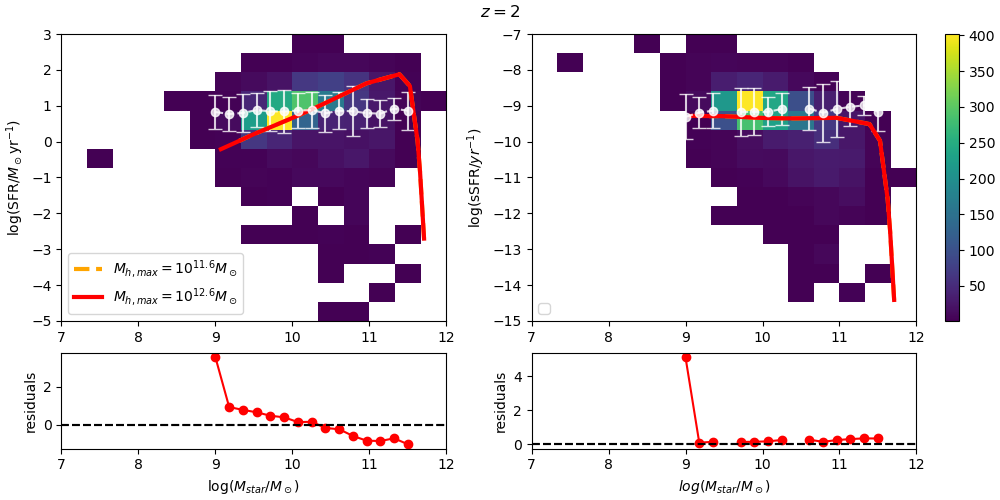

In [35]:


fig, axes = plt.subplots(2,2, figsize=(10,5),layout="constrained",gridspec_kw={'height_ratios': [3, 1]}) 
fig.suptitle('$z=2$') #fontsize=12

hist1 = axes[0,0].hist2d(np.log10(stellar_mass_3DHST_ ),np.log10(SFR_3DHST_), bins=[n_bins,n_bins], range=[[7, 12], [-5, 3]],cmin=1) #,SFR_best,bins = [bins_m,bins_sfr] n_bins,50], range=[[7, 12], [-12, 2]]
axes[0,0].errorbar(np.log10(bins_m), SFR_MS_medians, yerr = SFR_MS_disp, c='w',alpha=0.8,ls='--', marker='o', capsize=5, capthick=1) #yerr=MS_disp,
hist2 = axes[0,1].hist2d(np.log10(stellar_mass_3DHST_),np.log10(sSFR_3DHST_), bins=[n_bins,n_bins], range=[[7, 12], [-15,-7]],cmin=1)

axes[0,1].errorbar(np.log10(bins_m), sSFR_MS_medians, yerr = sSFR_MS_disp, c='w',alpha=0.8,ls='--', marker='o', capsize=5, capthick=1)
axes[1,0].set_xlabel("log($M_{star}/M_\odot$)") ; axes[1,1].set_xlabel("$log(M_{star}/M_\odot$)") ;
axes[0,0].set_ylabel("log(SFR/$M_\odot$yr$^{-1}$)") ; 
axes[0,1].set_ylabel("log(sSFR/$yr^{-1}$)") ; 
fig.colorbar(hist1[3],ax=axes[0,1], location="right",shrink=1.)

###########################################################################################################

#M_max=11.6

t_form_plot = np.linspace(0.01,1.5,100) #determines initial halo mass
M_h_form = 5.e8
t_z_2 = redshift_to_time(2)

M_s_today = [] ; SFR_today = [] ; sSFR_today = [] ; Z_today = []
for i in range(len(t_form_plot)):
    M_h, M_g, M_s, SFR, sSFR, Z = evolve_galaxy(t_form=t_form_plot[i],t_obs=t_z_2,M_h_in=M_h_form) #M_h_min=10**10.12,M_h_max=10**11.6
    if M_s[-1] > 1.e8 and M_s[-1]<10**16:
        M_s_today.append(M_s[-1])
        SFR_today.append(SFR[-1])
        sSFR_today.append(sSFR[-1])
        Z_today.append(Z[-1])
M_s_today = np.array(M_s_today) ; SFR_today = np.array(SFR_today) ; sSFR_today = np.array(sSFR_today) ; Z_today = np.array(Z_today)

residuals_SFR = [] ; residuals_sSFR = []
for i in range(n_bins): 
    M_s_today_ = M_s_today.copy() ; SFR_today_ = SFR_today.copy() ; sSFR_today_ = sSFR_today.copy()
    idx_order =  np.argsort(M_s_today_)
    M_s_today_ = M_s_today_[idx_order]
    SFR_today_ = SFR_today_[idx_order]
    sSFR_today_ = sSFR_today_[idx_order]
    j = np.digitize(bins_m[i],M_s_today_)-1 
    residuals_SFR.append(SFR_MS_medians[i]-np.log10(SFR_today_[j]))
    residuals_sSFR.append(sSFR_MS_medians[i]-np.log10(sSFR_today_[j]))
residuals_SFR = np.array(residuals_SFR) ; residuals_sSFR = np.array(residuals_sSFR)

#axes[1,0].plot(np.log10(bins_m),residuals_SFR,marker='o',c='orange')
axes[1,0].axhline(y=0,linestyle='--',c='black')
axes[1,0].set_xlim(7,12)
#axes[1,0].set_ylim(-2,2)

#axes[1,1].plot(np.log10(bins_m),residuals_sSFR,marker='o',c='orange')
axes[1,1].axhline(y=0,linestyle='--',c='black')
axes[1,1].set_xlim(7,12)
#axes[1,1].set_ylim(-2,2)

axes[0,0].plot(np.log10(M_s_today),np.log10(SFR_today),c='orange',linestyle='--',linewidth=3.0,label="$M_{h,max}=10^{11.6}M_\odot$")
axes[0,1].plot(np.log10(M_s_today),np.log10(sSFR_today),color='orange',linestyle='--',linewidth=3.0)

#M_max=12.8

t_form_plot = np.linspace(0.01,1.5,100) #determines initial halo mass
M_h_form = 5.e8
t_z_2 = redshift_to_time(2)

M_s_today = [] ; SFR_today = [] ; sSFR_today = [] ; Z_today = []
for i in range(len(t_form_plot)):
    M_h, M_g, M_s, SFR, sSFR, Z = evolve_galaxy(t_form=t_form_plot[i],t_obs=t_z_2,M_h_in=M_h_form) #M_h_min=10**10,M_h_max=10**12.6
    if M_s[-1] > 1.e9 and M_s[-1]<10**16:
        M_s_today.append(M_s[-1])
        SFR_today.append(SFR[-1])
        sSFR_today.append(sSFR[-1])
        Z_today.append(Z[-1])
M_s_today = np.array(M_s_today) ; SFR_today = np.array(SFR_today) ; sSFR_today = np.array(sSFR_today) ; Z_today = np.array(Z_today)

residuals_SFR = [] ; residuals_sSFR = []
for i in range(n_bins): 
    M_s_today_ = M_s_today.copy() ; SFR_today_ = SFR_today.copy() ; sSFR_today_ = sSFR_today.copy()
    idx_order =  np.argsort(M_s_today_)
    M_s_today_ = M_s_today_[idx_order]
    SFR_today_ = SFR_today_[idx_order]
    sSFR_today_ = sSFR_today_[idx_order]
    j = np.digitize(bins_m[i],M_s_today_)-1 
    residuals_SFR.append(SFR_MS_medians[i]-np.log10(SFR_today_[j]))
    residuals_sSFR.append(sSFR_MS_medians[i]-np.log10(sSFR_today_[j]))
residuals_SFR = np.array(residuals_SFR) ; residuals_sSFR = np.array(residuals_sSFR)

axes[1,0].plot(np.log10(bins_m),residuals_SFR,marker='o',c='red')
axes[1,0].axhline(y=0,linestyle='--',c='black')
axes[1,0].set_xlim(7,12)
#axes[1,0].set_ylim(-2,2)

axes[1,1].plot(np.log10(bins_m),residuals_sSFR,marker='o',c='red')
axes[1,1].axhline(y=0,linestyle='--',c='black')
axes[1,1].set_xlim(7,12)
#axes[1,1].set_ylim(-2,2)

axes[0,0].plot(np.log10(M_s_today),np.log10(SFR_today),c='red',linewidth=3.0,label="$M_{h,max}=10^{12.6}M_\odot$")
axes[0,1].plot(np.log10(M_s_today[M_s_today>0]),np.log10(sSFR_today[M_s_today>0]),color='red',linewidth=3.0)



axes[0,0].legend(loc='lower left') # bbox_to_anchor=(1, 0.5)
axes[0,1].legend(loc='lower left')

axes[1,0].set_ylabel("residuals")
axes[1,1].set_ylabel("residuals")

#axes[0,0].set_xticks([]) 
#axes[0,0].get_shared_x_axes().join(axes[0,0], axes[1,0])


plt.show()

/tmp/ipykernel_4450/1956076878.py:40: RuntimeWarning: invalid value encountered in scalar divide
  sSFR[i] = SFR[i]/M_s[i]
/tmp/ipykernel_4450/1956076878.py:50: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(Z/0.02) + 8.69


HEII2


/tmp/ipykernel_4450/2842574777.py:38: RuntimeWarning: divide by zero encountered in log10
  SFR_MS_bins[j].append(np.log10(SFR_3DHST_[i]))
/tmp/ipykernel_4450/2842574777.py:39: RuntimeWarning: divide by zero encountered in log10
  sSFR_MS_bins[j].append(np.log10(sSFR_3DHST_[i]))
/tmp/ipykernel_4450/2842574777.py:69: RuntimeWarning: divide by zero encountered in log10
  hist1 = axes[0,0].hist2d(np.log10(stellar_mass_3DHST_),np.log10(SFR_3DHST_), bins=[n_bins,n_bins], range=[[7, 12], [-6, 2]],cmin=1) #,SFR_best,bins = [bins_m,bins_sfr] n_bins,50], range=[[7, 12], [-12, 2]]
/tmp/ipykernel_4450/2842574777.py:72: RuntimeWarning: divide by zero encountered in log10
  hist2 = axes[0,1].hist2d(np.log10(stellar_mass_3DHST_),np.log10(sSFR_3DHST_), bins=[n_bins,n_bins], range=[[7, 12], [-16,-8]],cmin=1)
/tmp/ipykernel_4450/2842574777.py:78: RuntimeWarning: divide by zero encountered in log10
  axes[0,0].plot(np.log10(M_s_2),np.log10(SFR_2),color='red',linewidth=5.0)
/tmp/ipykernel_4450/2842574777

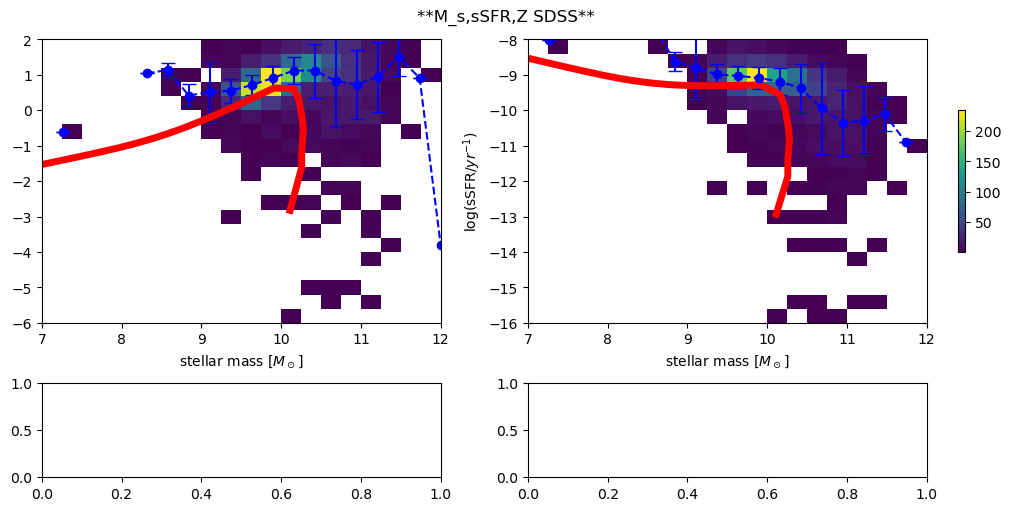

In [118]:
#3DHST DATA z = 2

t_form_plot = np.linspace(0.,2.5,100) #determines initial halo mass

M_h_form = 5.e8

t_z_2 = redshift_to_time(2)

M_s_2 = [] ; SFR_2 = [] ; sSFR_2 = [] ; Z_2 = []
for i in range(len(t_form_plot)):
    M_h, M_g, M_s, SFR, sSFR, Z = evolve_galaxy_OB(t_form=t_form_plot[i],t_obs=t_z_2,M_h_in=M_h_form)
    M_s_2.append(M_s[-1])
    SFR_2.append(SFR[-1])
    sSFR_2.append(sSFR[-1])
    Z_2.append(Z[-1])
M_s_2 = np.array(M_s_2) ; SFR_2 = np.array(SFR_2) ; sSFR_2 = np.array(sSFR_2) ; Z_2 = np.array(Z_2)

#######################################################################

stellar_mass_3DHST_ = stellar_mass_3DHST[redshift_3DHST>2]
SFR_3DHST_ = SFR_3DHST[redshift_3DHST>2]
sSFR_3DHST_ = sSFR_3DHST[redshift_3DHST>2]
stellar_mass_3DHST_ = stellar_mass_3DHST[redshift_3DHST>2]

n_bins = 20
bins_m = np.logspace(7,12,n_bins)
SFR_MS_bins = [ [] for _ in range(n_bins)]
sSFR_MS_bins = [ [] for _ in range(n_bins)]

for i in range(len(stellar_mass_3DHST_)): 
    j = np.digitize(stellar_mass_3DHST_[i],bins_m)-1
    SFR_MS_bins[j].append(np.log10(SFR_3DHST_[i])) 
    sSFR_MS_bins[j].append(np.log10(sSFR_3DHST_[i])) 


#statistics: we take medians as means and half the difference between 86th and 16th percentile
#much less subject to outliars than mean and median

SFR_MS_medians = [] ; sSFR_MS_medians = [] ; SFR_MS_disp = [] ; sSFR_MS_disp = []

for i in range(n_bins): 
    SFR_MS_medians.append(np.median(SFR_MS_bins[i]))
    sSFR_MS_medians.append(np.median(sSFR_MS_bins[i]))
    if len(SFR_MS_bins[i]) > 1: 
        SFR_MS_disp.append((np.percentile(SFR_MS_bins[i],86)-np.percentile(SFR_MS_bins[i],16))/2)
    else:
        SFR_MS_disp.append(0)
    if len(sSFR_MS_bins[i]) > 1: 
        sSFR_MS_disp.append((np.percentile(sSFR_MS_bins[i],86)-np.percentile(sSFR_MS_bins[i],16))/2)
    else:
        sSFR_MS_disp.append(0)
    #SFR_MS_disp = np.where(len(SFR_MS_bins[i])>2,(np.percentile(SFR_MS_bins[i],86)-np.percentile(SFR_MS_bins[i],16))/2,0)
    #sSFR_MS_disp = np.where(len(sSFR_MS_bins[i])>2,(np.percentile(sSFR_MS_bins[i],86)-np.percentile(sSFR_MS_bins[i],16))/2,0)


##############################################################################################


fig, axes = plt.subplots(2,2, figsize=(10,5),layout="constrained",gridspec_kw={'height_ratios': [3, 1]}) 
fig.suptitle('**M_s,sSFR,Z SDSS**') #fontsize=12

hist1 = axes[0,0].hist2d(np.log10(stellar_mass_3DHST_),np.log10(SFR_3DHST_), bins=[n_bins,n_bins], range=[[7, 12], [-6, 2]],cmin=1) #,SFR_best,bins = [bins_m,bins_sfr] n_bins,50], range=[[7, 12], [-12, 2]]
axes[0,0].errorbar(np.log10(bins_m), SFR_MS_medians, yerr = SFR_MS_disp, c='b',ls='--', marker='o', capsize=5, capthick=1) #yerr=MS_disp,

hist2 = axes[0,1].hist2d(np.log10(stellar_mass_3DHST_),np.log10(sSFR_3DHST_), bins=[n_bins,n_bins], range=[[7, 12], [-16,-8]],cmin=1)
#plt.colorbar(hist2[3], ax=axes[1], location="bottom",shrink=0.5)
axes[0,1].errorbar(np.log10(bins_m), sSFR_MS_medians, yerr = sSFR_MS_disp, c='b',ls='--', marker='o', capsize=5, capthick=1)

#axes[1].scatter(np.log10(stex, y, yerr=None, xerr=Nonellar_mass_best,np.log10(metallicity, s=1, color='black')

axes[0,0].plot(np.log10(M_s_2),np.log10(SFR_2),color='red',linewidth=5.0)
axes[0,1].plot(np.log10(M_s_2),np.log10(sSFR_2),color='red',linewidth=5.0)

#axes[1].plot(M_s_today,Z_today,color='blue',linewidth=5.0)


axes[0,0].set_xlabel("stellar mass [$M_\odot$]") ; axes[0,1].set_xlabel("stellar mass [$M_\odot$]") ;

axes[0,1].set_ylabel("log(sSFR/$yr^{-1}$)") ; #axes[0,0].set_title("Bayes estimator")

fig.colorbar(hist1[3],ax=axes[0,1], location="right",shrink=0.5)

#axes[1].set_ylabel("metallicity")




In [51]:
#Davé et al model

eps = 0.02 
eta = 0.3 #1.0
R = 0.52 
Z0 = 0
y = 0.016

f_b = 0.15
redshift_bins = [0,0.75,1.5,2.5,3]

M_h_form = 5.e8 # dm halo mass at t_form

def evolve_galaxy_Dave(t_form, t_obs, M_h_in):
    M_h = t*0 ; M_g = t*0 ; M_s = t*0 ; SFR = t*0 ; sSFR = t*0 ; Z = t*0
    i = 0
    for i in range(len(t)):
        if t[i]<t_form : 
            M_h[i] = M_h_in
        elif t[i]<t_obs:
            #M_dot_h = 42.0*((M_h[i-1]/1.e12)**1.127)*(1+1.17*z[i])*(0.3*(1+z[i])**3+0.7)**0.5 #M_sun/yr
            M_dot_h = 510*((M_h[i-1]/1.e12)**1.1)*((1+z[i])/3.12)**2.2 #M_sun/yr
            M_h[i] = M_h[i-1]+M_dot_h*dt*1.e9
            
            t_dyn = 2.e7*((1+z[i])/3.2)**(-3/2)

            M_dot_g = f_b * zeta(M_h[i],z[i]) * M_dot_h - (eps/t_dyn) * (1+eta-R) * M_g[i-1]#M_sun/yr
            M_g[i] = M_g[i-1]+ dt*1.e9*M_dot_g
            SFR[i] = eps*M_g[i]/t_dyn
            M_s[i] = M_s[i-1]+ SFR[i]*dt*1.e9
            sSFR[i] = SFR[i]/M_s[i]
            Z_dot = (y*(1-R)-(Z[i-1]-Z0)*(1-R+eta))*(eps/t_dyn) - (Z[i-1]-Z0) * M_dot_g/M_g[i-1] if M_g[i-1] > 0 else 0
            Z[i] = (Z[i-1] + dt*1.e9*Z_dot)
        else:
            M_h[i] = M_h[i-1]
            M_g[i] = M_g[i-1]
            M_s[i] = M_s[i-1]
            SFR[i] = SFR[i-1]
            sSFR[i] = sSFR[i-1]
            Z[i] = Z[i-1]
    Z = np.log10(Z/0.02) + 8.69
    return M_h, M_g, M_s, SFR, sSFR, Z

/tmp/ipykernel_45902/3182950448.py:31: RuntimeWarning: divide by zero encountered in log10
  h1 = axes2[i].hist2d(np.log10(stellar_mass_3DHST_),np.log10(SFR_3DHST_), bins=[n_bins,n_bins], range=[[7, 12], [-4, 3]],cmin=1)


NameError: name 'plots' is not defined

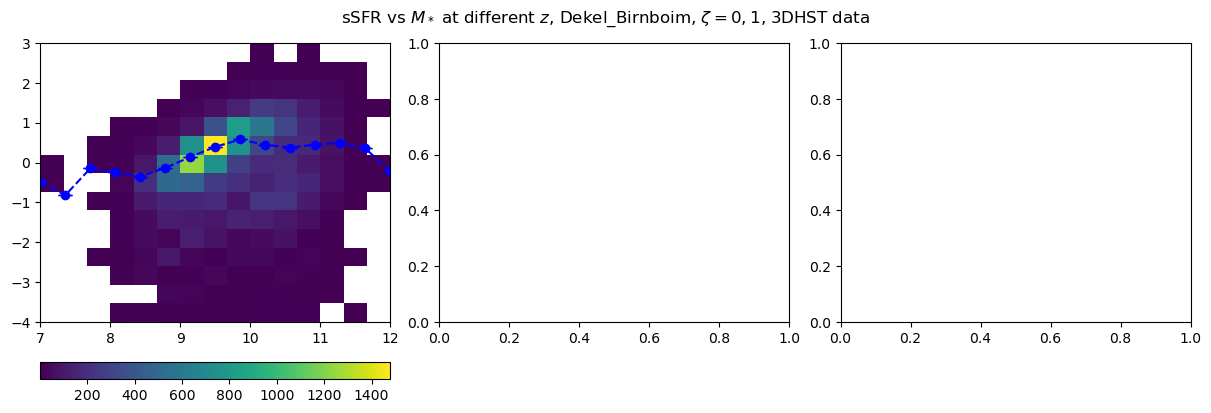

In [18]:


fig, axes2 = plt.subplots(1, 3, figsize=(12,4),layout="constrained") 
fig.suptitle('sSFR vs $M_*$ at different $z$, Dekel_Birnboim, $\zeta=0,1$, 3DHST data')

for i in range(3):

    stellar_mass_3DHST_ = stellar_mass_3DHST[np.logical_and(redshift_3DHST>redshift_bins[i],redshift_3DHST<redshift_bins[i+1])]
    SFR_3DHST_ = SFR_3DHST[np.logical_and(redshift_3DHST>redshift_bins[i],redshift_3DHST<redshift_bins[i+1])]
   
    n_bins = 15
    bins_m = np.logspace(7,12,n_bins)
    
    SFR_MS_bins = [ [] for _ in range(n_bins)]
    #sSFR_MS_bins = [ [] for _ in range(n_bins)]
    
    for k in range(len(stellar_mass_3DHST_)): 
        j = np.digitize(stellar_mass_3DHST_[k],bins_m)-1
        if SFR_3DHST_[k] > 1.e-1: #M_halo_data[i] < M_crit(0): 
            SFR_MS_bins[j].append(np.log10(SFR_3DHST_[k])) 
            #sSFR_MS_bins[j].append(np.log10(sSFR_3DHST_[k])) 
    
    SFR_MS_means = [] ; SFR_MS_disp = [] #; sSFR_MS_means = [] ; sSFR_MS_disp = []
    
    for k in range(n_bins): 
        SFR_MS_means.append(np.mean(SFR_MS_bins[k]))
        #sSFR_MS_means.append(np.mean(sSFR_MS_bins[i]))
        SFR_MS_disp = np.where(len(SFR_MS_bins[k])>1,np.std(SFR_MS_bins[k])/np.sqrt(len(SFR_MS_bins[k])),0)
        #SFR_MS_disp = np.where(len(SFR_MS_bins[i])>1,(np.percentile(SFR_MS_bins[i],86)-np.percentile(SFR_MS_bins[i],16))/2,0)
        sSFR_MS_disp = np.where(len(sSFR_MS_bins[i])>1,np.std(sSFR_MS_bins[i])/np.sqrt(len(SFR_MS_bins[i])),0)
        #print(SFR_MS_disp)

    h1 = axes2[i].hist2d(np.log10(stellar_mass_3DHST_),np.log10(SFR_3DHST_), bins=[n_bins,n_bins], range=[[7, 12], [-4, 3]],cmin=1)
    
    axes2[i].errorbar(np.log10(bins_m), SFR_MS_means, yerr = SFR_MS_disp, c='b',ls='--', marker='o', capsize=5, capthick=1)
    plt.colorbar(h1[3], ax=axes2[i], location="bottom")

    axes2[i].plot(plots[i][0],plots[i][1], c='black',linestyle='-',label="z=%.2f"%redshift_bins[i],linewidth=2) 
    axes2[i].plot(plots[i+1][0],plots[i+1][1], c='black',linestyle='--',label="z=%.2f"%redshift_bins[i+1],linewidth=2)

    axes2[i].set_xlabel("stellar mass [$M_\odot$]")
    axes2[i].legend(loc='upper left')
    #axes2[i].set_ylim(-3,2)

axes2[0].set_ylabel("log(SFR/$yr^{-1}$)")
axes2[0].set_title("$0<z<1$")
axes2[1].set_title("$1<z<2$")
axes2[2].set_title("$2<z<3$")

plt.show()


<ErrorbarContainer object of 3 artists>

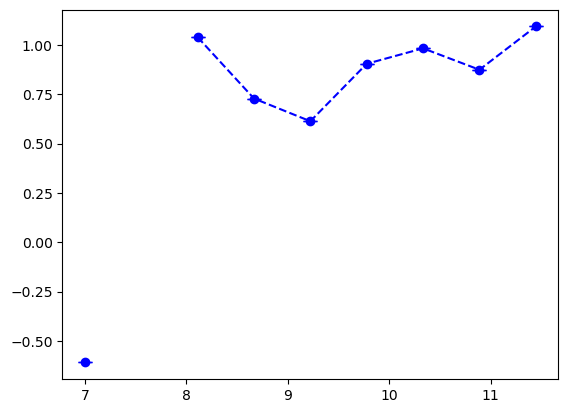

In [283]:
plt.errorbar(np.log10(bins_m), SFR_MS_means, yerr = SFR_MS_disp, c='b',ls='--', marker='o', capsize=5, capthick=1)

In [288]:
exp=[1,2,3,4,3,2]
obs=[1.1,2,3,3.5,3.6,2]
scipy.stats.chisquare(f_obs=obs, f_exp=exp)

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.013333333333333286

**GALACTIC ENVIRONMENT AND SSFR**

/tmp/ipykernel_19002/3815917087.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('jet_r')


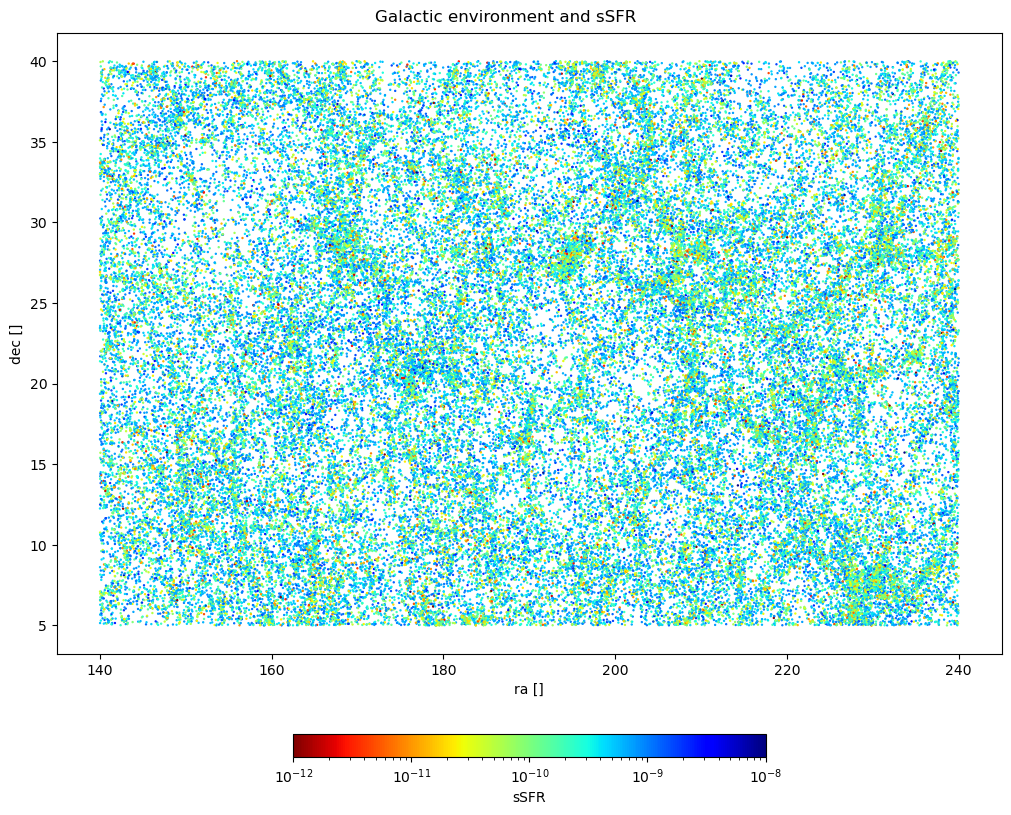

In [226]:
#plot galactic environment vs sSFR

fig, axes = plt.subplots(figsize=(10,8),layout="constrained") 
fig.suptitle('Galactic environment and sSFR') #fontsize=12

cmap_reversed = plt.cm.get_cmap('jet_r')
S = plt.scatter(ra,dec,c=sSFR_bayes,cmap=cmap_reversed,norm=colors.LogNorm(vmin=1.e-12, vmax=1.e-8),s=0.5) #np.log10(sSFR_bayes)
#plt.xlim(180,220) 
#plt.ylim(25,35)
plt.xlabel("ra []") ; plt.ylabel("dec []")

plt.colorbar(S, ax=axes, location='bottom', shrink=0.5, label='sSFR') 
plt.show()

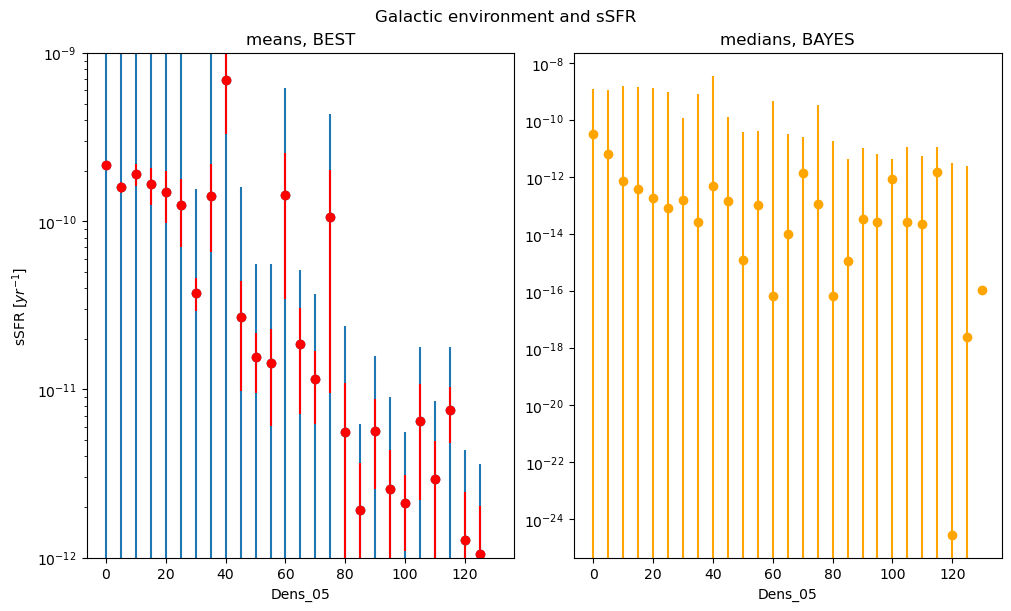

In [287]:
fig, axes = plt.subplots(1, 2, figsize=(10,6),layout="constrained") 
fig.suptitle('Galactic environment and sSFR') #fontsize=12
rho = np.arange(0,max(Dens_05),5) #densities

sfr_means = []
sfr_medians = []
sfr_sigma = []
sfr_err_mean = []

for i in range(len(rho)):
    sSFR_best_ = sSFR_best[np.where(rho[i]<Dens_05)] # and Dens_05
    Dens_05_ = Dens_05[np.where(rho[i]<Dens_05)]
    if i < len(rho)-1: sSFR_best_ = sSFR_best_[np.where(Dens_05_<rho[i+1])]
    sfr_medians.append(np.median(sSFR_best_))
    sfr_means.append(np.mean(sSFR_best_))
    sfr_sigma.append(np.std(sSFR_best_))
    sfr_err_mean.append(np.std(sSFR_best_)/np.sqrt(len(sSFR_best_)))


axes[0].errorbar(rho, sfr_means, yerr=sfr_sigma, fmt='o') #linestyle=None 
axes[0].errorbar(rho, sfr_means, yerr=sfr_err_mean,fmt='o',c='red')
axes[1].errorbar(rho, sfr_medians, yerr=sfr_sigma, fmt='o',c='orange') #linestyle=None 

axes[0].set_ylim(1.e-12,1.e-9) ; #axes[1].set_ylim(1.e-12,1.e-9)
axes[0].set_yscale('log') 
axes[1].set_yscale('log') 

axes[0].set_title("means, BEST") ; axes[1].set_title("medians, BAYES")
axes[0].set_xlabel("Dens_05") ; axes[1].set_xlabel("Dens_05")
axes[0].set_ylabel("sSFR [$yr^{-1}$]")

plt.show()

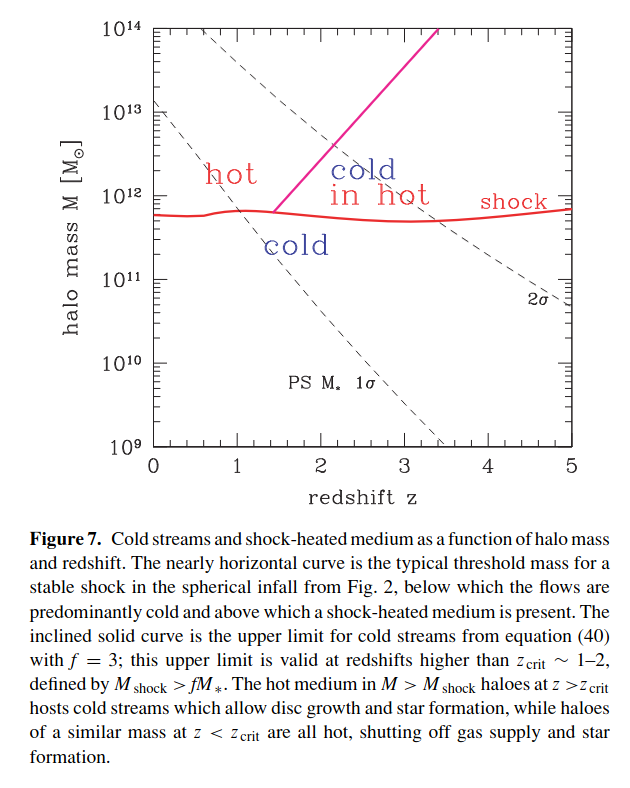

In [ ]:
#condition for steady state 
#t_accr = 

In [13]:
#parameters
eps = 0.02 
eta = 1.0
#eta = 0.5
#gamma AGN
R = 0.52 #R=0.1
f_b = 0.15
#f_b = 0.25
#M_h_min = 1.e9/f_b

M_h_form = 5.e8 # dm halo mass at t_form

def evolve_galaxy_Dekel_Birnboim(t_form, t_obs, M_h_in):
    M_h = t*0 ; M_g = t*0 ; M_s = t*0 ; SFR = t*0 ; sSFR = t*0
    i = 0
    for i in range(len(t)):
        if t[i]<t_form : 
            M_h[i] = M_h_in
        elif t[i]<t_obs:
            #M_dot_h = 42.0*((M_h[i-1]/1.e12)**1.127)*(1+1.17*z[i])*(0.3*(1+z[i])**3+0.7)**0.5 #M_sun/yr
            M_dot_h = 510*((M_h[i-1]/1.e12)**1.1)*((1+z[i])/3.2)**2.2 
            M_h[i] = M_h[i-1]+M_dot_h*dt*1.e9

            t_dyn = 2.e7*((1+z[i])/3.2)**(-3/2)

            M_h_min = 1.e9/f_b
            
            M_h_max = 10**11.6 if z[i] < 1.4 else 10**(z[i]+10.2) #cold accretion in hot halo
            
            if M_h[i]<M_h_min: csi=0.0
            elif M_h[i]>M_h_min and M_h[i]<M_h_max: csi=1.0 #1.0
            else: csi = 0.0

            M_g[i] = M_g[i-1]+dt*1.e9*(f_b*csi*M_dot_h-eps*(1+eta-R)*M_g[i-1]/t_dyn)
            SFR[i] = eps*M_g[i]/t_dyn
            M_s[i] = M_s[i-1]+SFR[i]*dt*1.e9
            sSFR[i] = SFR[i]/M_s[i]
        else: #???
            M_h[i] = M_h[i-1]
            M_g[i] = M_g[i-1]
            M_s[i] = M_s[i-1]
            SFR[i] = SFR[i-1]
            sSFR[i] = sSFR[i-1]
    return M_h, M_g, M_s, SFR, sSFR

/tmp/ipykernel_8401/618835417.py:36: RuntimeWarning: invalid value encountered in scalar divide
  sSFR[i] = SFR[i]/M_s[i]
/tmp/ipykernel_8401/453275555.py:37: RuntimeWarning: invalid value encountered in divide
  f_g = M_g/(M_g+M_s)
/tmp/ipykernel_8401/453275555.py:75: RuntimeWarning: divide by zero encountered in log10
  axes2[0].plot(np.log10(plots_SFR[i,0]),np.log10(plots_SFR[i,1]),c='black',linestyle=linestyle_arr[i],linewidth=1,label="z=%.2f"%redshift_bins[i]) #,linestyle=linestyle_arr[i]
/tmp/ipykernel_8401/453275555.py:76: RuntimeWarning: divide by zero encountered in log10
  axes2[1].plot(np.log10(plots_sSFR[i,0]),np.log10(plots_sSFR[i,1]),c='black',linestyle=linestyle_arr[i],linewidth=1,label="z=%.2f"%redshift_bins[i]) #linestyle='--'


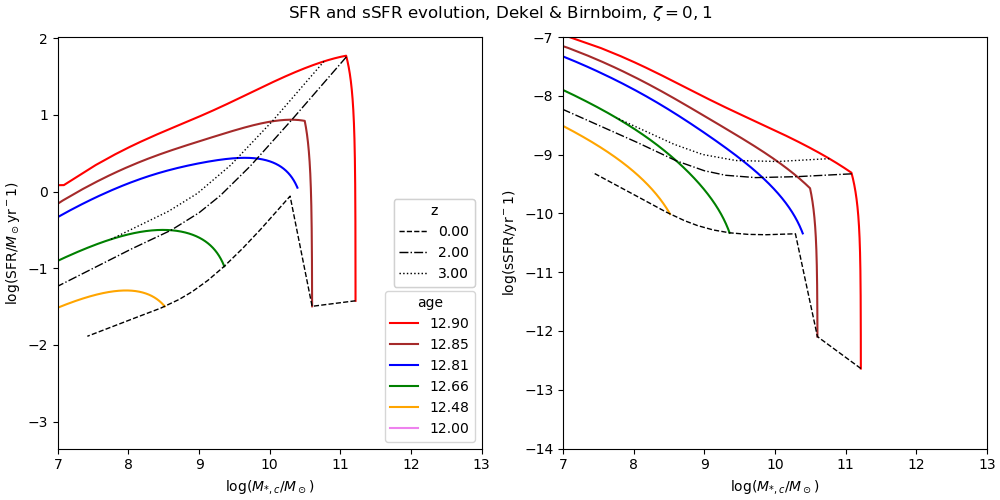

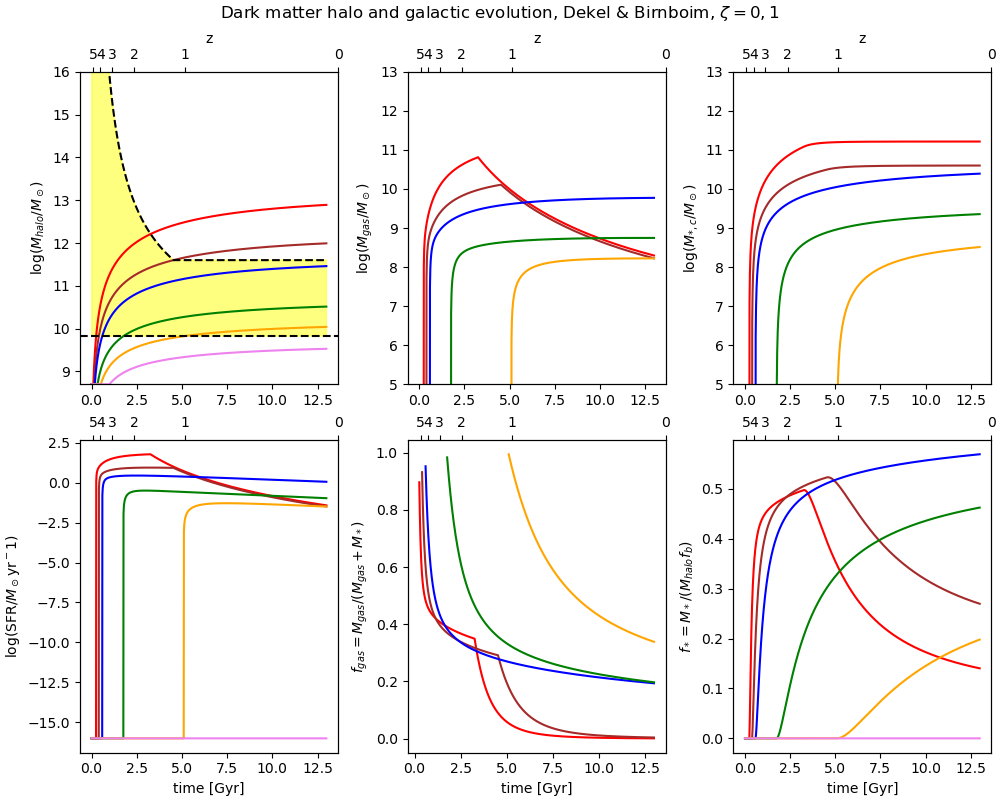

In [27]:
#set global arrays
dt=0.01 #Gyr
t = np.arange(dt,13.0,dt) #Gyr
z = t*0
for i in range(len(t)):
    z[i] = time_to_redshift(t[i])

fig, axes = plt.subplots(2,3, figsize=(10,8),layout="constrained") 
fig.suptitle('Dark matter halo and galactic evolution, Dekel & Birnboim, $\zeta=0,1$') #fontsize=12

axes[0,0].set_ylabel("log($M_{halo}/M_\odot$)")
axes[0,1].set_ylabel("log($M_{gas}/M_\odot$)")
axes[0,2].set_ylabel("log($M_{*,c}/M_\odot$)")
axes[1,0].set_ylabel("log(SFR/$M_\odot$yr$^-1$)")
axes[1,1].set_ylabel("$f_{gas}=M_{gas}/(M_{gas}+M_*)$")
axes[1,2].set_ylabel("$f_*=M_*/(M_{halo}f_b)$")


for i in range(3):
    axes[1,i].set_xlabel("time [Gyr]") 
    axes[0,i].twiny().set(xticks=age_ticks,xticklabels=['{:g}'.format(z_tick) for z_tick in redshift_ticks],xlabel="z")
    axes[1,i].twiny().set(xticks=age_ticks,xticklabels=['{:g}'.format(z_tick) for z_tick in redshift_ticks])

fig2, axes2 = plt.subplots(1, 2, figsize=(10,5),layout="constrained") 
fig2.suptitle('SFR and sSFR evolution, Dekel & Birnboim, $\zeta=0,1$') #fontsize=12
axes2[0].set_xlabel("log($M_{*,c}/M_\odot$)") ; axes2[1].set_xlabel("log($M_{*,c}/M_\odot$)")
axes2[0].set_ylabel("log(SFR/$M_\odot$yr$^-1$)")
axes2[1].set_ylabel("log(sSFR/yr$^-1$)")


t_form_plot = [0.10,0.15,0.19,0.34,0.52,1.00] #,0.16
#col_plot = ["red","darkred","brown","crimson","orange","green","blue","violet"]
col_plot = ["red","brown","blue","green","orange","violet"]

for i in range(len(t_form_plot)):
    M_h, M_g, M_s, SFR, sSFR = evolve_galaxy_Dekel_Birnboim(t_form=t_form_plot[i],t_obs=13,M_h_in=M_h_form)
    f_g = M_g/(M_g+M_s)
    f_s = M_s/(M_h*f_b)
    axes[0,0].plot(t,np.log10(np.where(M_h>0,M_h,1)),c=col_plot[i])
    axes[0,1].plot(t,np.log10(np.where(M_g>0,M_g,1)),c=col_plot[i])
    axes[0,2].plot(t,np.log10(np.where(M_s>0,M_s,1)),c=col_plot[i])
    axes[1,0].plot(t,np.log10(np.where(SFR>0,SFR,1.e-16)),c=col_plot[i])
    axes[1,1].plot(t,f_g,c=col_plot[i]) #np.log10(np.where(SFR>0,SFR,1.e-16))
    axes[1,2].plot(t,f_s,c=col_plot[i])
    
    axes2[0].plot(np.log10(np.where(M_s>0,M_s,1.0)),np.log10(np.where(SFR>0,SFR,1.0)),c=col_plot[i],label="age=%.2f"%(13-t_form_plot[i])) #np.where(M_s>0,M_s,1.0)
    axes2[1].plot(np.log10(np.where(M_s>0,M_s,1.0)),np.log10(np.where(sSFR>0,sSFR,1.0)),c=col_plot[i])

leg1 = axes2[0].legend(handles=plots1, loc="lower right", title="age")
axes2[0].add_artist(leg1)

axes[0,0].axhline(y=np.log10(1.e9/f_b),c='black',linestyle='--')
#axes[0].axhline(y=np.log10(10**11.6),c='black',linestyle='--')
m_max_dekel_birboin = np.where(time_to_redshift(t)>1.4,time_to_redshift(t)+10.2,11.6)
axes[0,0].plot(t,m_max_dekel_birboin,c='black',linestyle='--')
axes[0,0].fill_between(t,np.log10(1.e9/f_b),m_max_dekel_birboin, color='yellow',alpha=0.5)

redshift_bins = [0,2,3]
t_form_plot = np.linspace(0.10,1.,20) #determines initial halo mass
plots_SFR = [] ; plots_sSFR = []
for i in range(len(redshift_bins)):
    M_s_z = [] ; SFR_z = [] ; sSFR_z = []
    for j in range(len(t_form_plot)):
        k = np.digitize(redshift_bins[i],z)-1
        M_h, M_g, M_s, SFR, sSFR = evolve_galaxy_Dekel_Birnboim(t_form=t_form_plot[j],t_obs=13,M_h_in=M_h_form)
        M_s_z.append(M_s[k])
        SFR_z.append(SFR[k])
        sSFR_z.append(sSFR[k])
    plots_SFR.append([M_s_z,SFR_z])
    plots_sSFR.append([M_s_z,sSFR_z])
plots_SFR = np.array(plots_SFR) ; plots_sSFR = np.array(plots_sSFR)

linestyle_arr = ['--','-.',':']
for i in range(len(redshift_bins)):
    axes2[0].plot(np.log10(plots_SFR[i,0]),np.log10(plots_SFR[i,1]),c='black',linestyle=linestyle_arr[i],linewidth=1,label="z=%.2f"%redshift_bins[i]) #,linestyle=linestyle_arr[i]
    axes2[1].plot(np.log10(plots_sSFR[i,0]),np.log10(plots_sSFR[i,1]),c='black',linestyle=linestyle_arr[i],linewidth=1,label="z=%.2f"%redshift_bins[i]) #linestyle='--'

leg2 = axes2[0].legend(handles=plots2, loc="center right", title="z")
axes2[0].add_artist(leg2)

axes[0,0].set_ylim(8.7,16)
axes[0,1].set_ylim(5,13)
axes[0,2].set_ylim(5,13)

axes2[0].set_xlim(7,13) ; axes2[1].set_xlim(7,13)
axes2[1].set_ylim(-14,-7)

plt.show()



**Davé, Finlator, Oppenheimer model**

equilibrium condition:
$$\dot{M}_{in}=\dot{M}_{grav}-\dot{M}_{prev}+\dot{M}_{recyc}$$

mass loading factor $\eta=\dot{M}_{in}/\dot{M}_*$:
$$SFR = \dot{M}_{in}/(1+\eta)$$ 

cosmology by DEkel et al. (2009)
$$\frac{\dot{M}_{grav}}{M_{halo}}=0.47f_bM_{halo,12}^{0.15}\left(\frac{1+z}{3}\right)^{2.25} \text{Gyr}^{-1}$$

different parametrizations:
$$\dot{M}_{grav}=25.3M_{halo}^{0.1}(1+65z)\sqrt{\Omega_m(1+z)^3+\Omega_\Lambda} M_\odot\text{yr}^{-1}$$


preventive feedback parameter $\zeta$: the amount of gas that accretes to the central forming galaxy.

$\dot{M}_{recyc}$: gas infalling that has previously been ejected in outflows.

$$\dot{M}_{in}=\zeta\dot{M}_{grav}+\dot{M}_{recyc}$$

$\dot{M}_{grav}$ driven by gravity and independent on feedback processes. 

$\zeta_{photo}$: suppression of inflow owing to photoionization heating. OPerates at low masses and approaches zero below a photosuppression mass $M_\gamma\approx 10^8 - 10^9 M_\odot$

$\zeta_{quench}$: suppresses star formation in massive haloes. feedback from supermassive black holes. Drops to zero above the quenching mass $M_q\approx 10^{12} M_\odot$.

$\zeta_{grav}$ suppression of inflow by ambient gas heating due to virial shocks. (neglecting metal line cooling):

$$\zeta_{grav}\approx0.47\left(\frac{1+z}{4}\right)^{0.38}M_{halo,12}^{-0.25}$$

$\zeta_{winds}$ associated with additional heating of surrounding gas provided by energetic inputs from winds. It's a preventive feedback parameter, while $\eta$ ejective feedback. 

Metallicity:

$$Z_{ISM}=y\frac{SFR}{\dot{M}_{in}}=\frac{y}{1+\eta}\frac{1}{1-\alpha_Z}$$

$y$ is the yield, $\alpha_Z=Z_{in}/Z_{ISM}$: $\eta$ depends strongly on mass and weakly on redshift, $\alpha_Z$ is generally strong but has a significant redshift dependence. 

The vast majorities of metals in IGM are deposited by outflows: $Z_{in}$ is given by the metals arriving in the form of recycled winds, devided by the total mass inflow rate. 

$$Z_{in}=Z_{recyc}\frac{\dot{M}_{recyc}}{\dot{M}_{recyc}+\zeta\dot{M}_{grav}}$$

$Z_{out}\approx Z_{ISM}$. Galaxies evolve slowly in metallicity: Z has not evolved strongly from when the gas was ejected to when it was reaccreted: $Z_{recyc}\approx Z_{out}$

$$\dot{M}_{recyc}=\frac{\alpha_Z}{1-\alpha_Z}\zeta \dot{M}_{grav}$$


$$SFR = \frac{\zeta \dot{M}_{grav}}{(1+\eta)(1-\alpha_Z)}$$

Galaxies will tend to lie around these
relations owing to a balance of inflow, outflow and star formation.
The equilibrium relations depend on three parameters: η, ζ and
α Z , representing ejective feedback (i.e. outflows), preventive feed-
back and wind recycling. Additionally, the star formation law gov-
erns tdep , ˙Mgrav is set by cosmology, and y is set by nucleosynthetic
processes. Assuming those are well established, the mass and red-
shift (and possibly environmental) dependence of η, ζ and αZ gov-
ern the evolution of the global SFR, fgas and ZISM of galaxies. Note
that since the mass and redshift dependence of these parameters
are not fully known, the actual number of free parameters can be
significantly larger than three

$$\zeta=\frac{SFR}{\dot{M}_{grav}}\frac{y}{Z_{ISM}}$$

The first ratio is the halo star formation efficiency (SFE), i.e. the
fraction of gravitational infall into a halo that ends up forming into
stars,2 while the second ratio quantifies the metal retention fraction
within galaxies. If the halo mass and metal yield can be determined,
measuring SFR/ZISM provides a quantitative constraint on ζ . 




In [26]:
#evolve galaxy model 2

#parameters
#eps = 0.02 
eta = 2.0
#R = 0.52 
f_b = 0.15

M_h_form = 1.e9 # dm halo mass at t_form #5.e8


def evolve_galaxy_Dave(t_form, t_obs, M_h_in):
    M_h = t*0 ; M_g = t*0 ; M_s = t*0 ; SFR = t*0 ; sSFR = t*0
    i = 0
    for i in range(len(t)):
        if t[i]<t_form : 
            M_h[i] = M_h_in
        elif t[i]<t_obs:
            M_dot_h = 42.0*((M_h[i-1]/1.e12)**1.127)*(1+1.17*z[i])*(0.3*(1+z[i])**3+0.7)**0.5 #M_sun/yr
            M_h[i] = M_h[i-1]+M_dot_h*dt*1.e9
            
            t_dyn = 2.e7*((1+z[i])/3.2)**(-3/2)
            M_g[i] = M_g[i-1]+dt*1.e9*(f_b*zeta(M_h[i],z[i])*M_dot_h-eps*(1+eta-R)*M_g[i-1]/t_dyn)
            SFR[i] = eps*M_g[i]/t_dyn
            M_s[i] = M_s[i-1]+SFR[i]*dt*1.e9
            sSFR[i] = SFR[i]/M_s[i]
        else:
            M_h[i] = M_h[i-1]
            M_g[i] = M_g[i-1]
            M_s[i] = M_s[i-1]
            SFR[i] = SFR[i-1]
            sSFR[i] = sSFR[i-1]
    return M_h, M_g, M_s, SFR, sSFR

/tmp/ipykernel_13487/889782026.py:39: RuntimeWarning: invalid value encountered in divide
  f_g = M_g/(M_g+M_s)


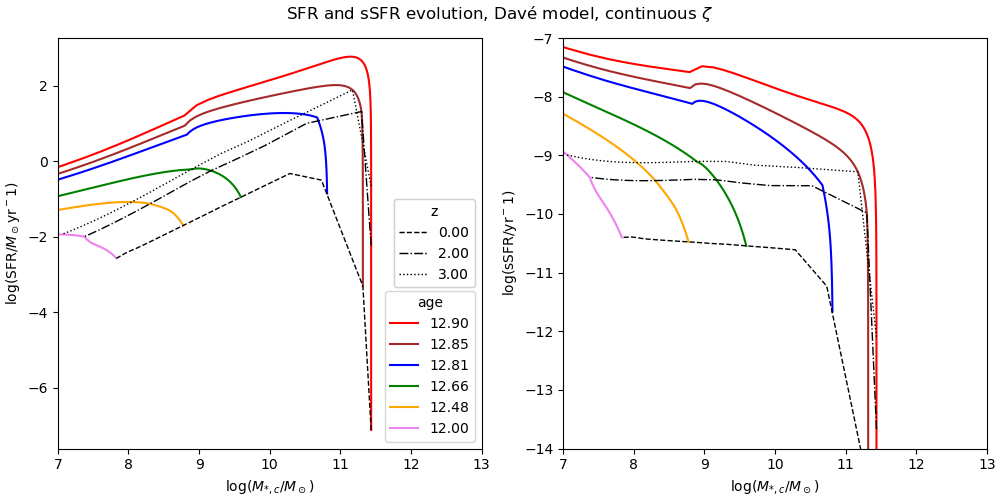

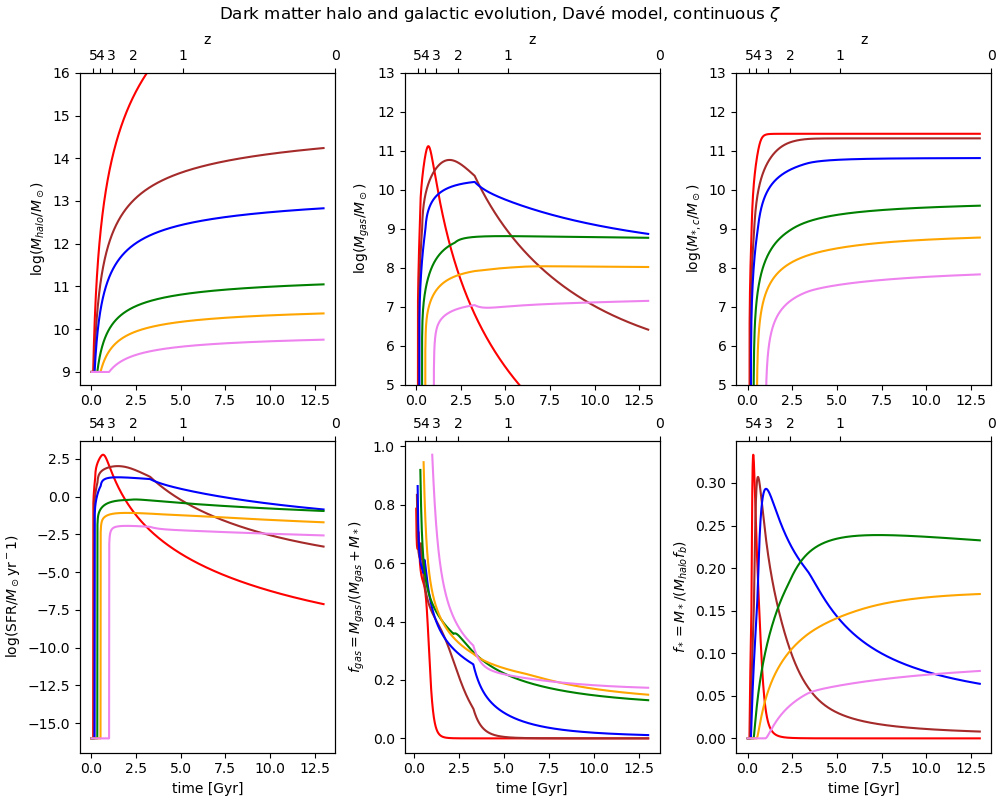

In [27]:
%matplotlib widget
#set global arrays
dt=0.01 #Gyr
t = np.arange(dt,13.0,dt) #Gyr
z = t*0
for i in range(len(t)):
    z[i] = time_to_redshift(t[i])

fig, axes = plt.subplots(2,3, figsize=(10,8),layout="constrained") 
fig.suptitle('Dark matter halo and galactic evolution, Davé model, continuous $\zeta$') #fontsize=12

axes[0,0].set_ylabel("log($M_{halo}/M_\odot$)")
axes[0,1].set_ylabel("log($M_{gas}/M_\odot$)")
axes[0,2].set_ylabel("log($M_{*,c}/M_\odot$)")
axes[1,0].set_ylabel("log(SFR/$M_\odot$yr$^-1$)")
axes[1,1].set_ylabel("$f_{gas}=M_{gas}/(M_{gas}+M_*)$")
axes[1,2].set_ylabel("$f_*=M_*/(M_{halo}f_b)$")


for i in range(3):
    axes[1,i].set_xlabel("time [Gyr]") 
    axes[0,i].twiny().set(xticks=age_ticks,xticklabels=['{:g}'.format(z_tick) for z_tick in redshift_ticks],xlabel="z")
    axes[1,i].twiny().set(xticks=age_ticks,xticklabels=['{:g}'.format(z_tick) for z_tick in redshift_ticks])


fig2, axes2 = plt.subplots(1, 2, figsize=(10,5),layout="constrained") 
fig2.suptitle('SFR and sSFR evolution, Davé model, continuous $\zeta$') #fontsize=12
axes2[0].set_xlabel("log($M_{*,c}/M_\odot$)") ; axes2[1].set_xlabel("log($M_{*,c}/M_\odot$)")
axes2[0].set_ylabel("log(SFR/$M_\odot$yr$^-1$)")
axes2[1].set_ylabel("log(sSFR/yr$^-1$)")


t_form_plot = [0.10,0.15,0.19,0.34,0.52,1.00] #,0.16
#col_plot = ["red","darkred","brown","crimson","orange","green","blue","violet"]
col_plot = ["red","brown","blue","green","orange","violet"]

for i in range(len(t_form_plot)):
    M_h, M_g, M_s, SFR, sSFR = evolve_galaxy_Dave(t_form=t_form_plot[i],t_obs=13,M_h_in=M_h_form)
    f_g = M_g/(M_g+M_s)
    f_s = M_s/(M_h*f_b)
    axes[0,0].plot(t,np.log10(np.where(M_h>0,M_h,1)),c=col_plot[i])
    axes[0,1].plot(t,np.log10(np.where(M_g>0,M_g,1)),c=col_plot[i])
    axes[0,2].plot(t,np.log10(np.where(M_s>0,M_s,1)),c=col_plot[i])
    axes[1,0].plot(t,np.log10(np.where(SFR>0,SFR,1.e-16)),c=col_plot[i])
    axes[1,1].plot(t,f_g,c=col_plot[i]) #np.log10(np.where(SFR>0,SFR,1.e-16))
    axes[1,2].plot(t,f_s,c=col_plot[i])
    
    axes2[0].plot(np.log10(np.where(M_s>0,M_s,1.0)),np.log10(np.where(SFR>0,SFR,1.0)),c=col_plot[i],label="age=%.2f"%(13-t_form_plot[i])) #np.where(M_s>0,M_s,1.0)
    axes2[1].plot(np.log10(np.where(M_s>0,M_s,1.0)),np.log10(np.where(sSFR>0,sSFR,1.0)),c=col_plot[i])

leg1 = axes2[0].legend(handles=plots1, loc="lower right", title="age")
axes2[0].add_artist(leg1)

redshift_bins = [0,2,3]
t_form_plot = np.linspace(0.10,1.,20) #determines initial halo mass
plots_SFR = [] ; plots_sSFR = []
for i in range(len(redshift_bins)):
    M_s_z = [] ; SFR_z = [] ; sSFR_z = []
    for j in range(len(t_form_plot)):
        k = np.digitize(redshift_bins[i],z)-1
        M_h, M_g, M_s, SFR, sSFR = evolve_galaxy_Dave(t_form=t_form_plot[j],t_obs=13,M_h_in=M_h_form)
        M_s_z.append(M_s[k])
        SFR_z.append(SFR[k])
        sSFR_z.append(sSFR[k])
    plots_SFR.append([M_s_z,SFR_z])
    plots_sSFR.append([M_s_z,sSFR_z])
plots_SFR = np.array(plots_SFR) ; plots_sSFR = np.array(plots_sSFR)

linestyle_arr = ['--','-.',':']
for i in range(len(redshift_bins)):
    axes2[0].plot(np.log10(plots_SFR[i,0]),np.log10(plots_SFR[i,1]),c='black',linestyle=linestyle_arr[i],linewidth=1,label="z=%.2f"%redshift_bins[i]) #,linestyle=linestyle_arr[i]
    axes2[1].plot(np.log10(plots_sSFR[i,0]),np.log10(plots_sSFR[i,1]),c='black',linestyle=linestyle_arr[i],linewidth=1,label="z=%.2f"%redshift_bins[i]) #linestyle='--'

leg2 = axes2[0].legend(handles=plots2, loc="center right", title="z")
axes2[0].add_artist(leg2)

axes[0,0].set_ylim(8.7,16)
axes[0,1].set_ylim(5,13)
axes[0,2].set_ylim(5,13)

axes2[0].set_xlim(7,13) ; axes2[1].set_xlim(7,13)
axes2[1].set_ylim(-14,-7)

plt.show()




/tmp/ipykernel_19002/99219760.py:9: RuntimeWarning: invalid value encountered in divide
  if H_alpha[i]/H_alpha_err[i]>StN and H_beta[i]/H_beta_err[i]>StN and OIII_5007[i]/OIII_5007_err[i]>StN and NII_6584[i]/NII_6584_err[i]>StN:


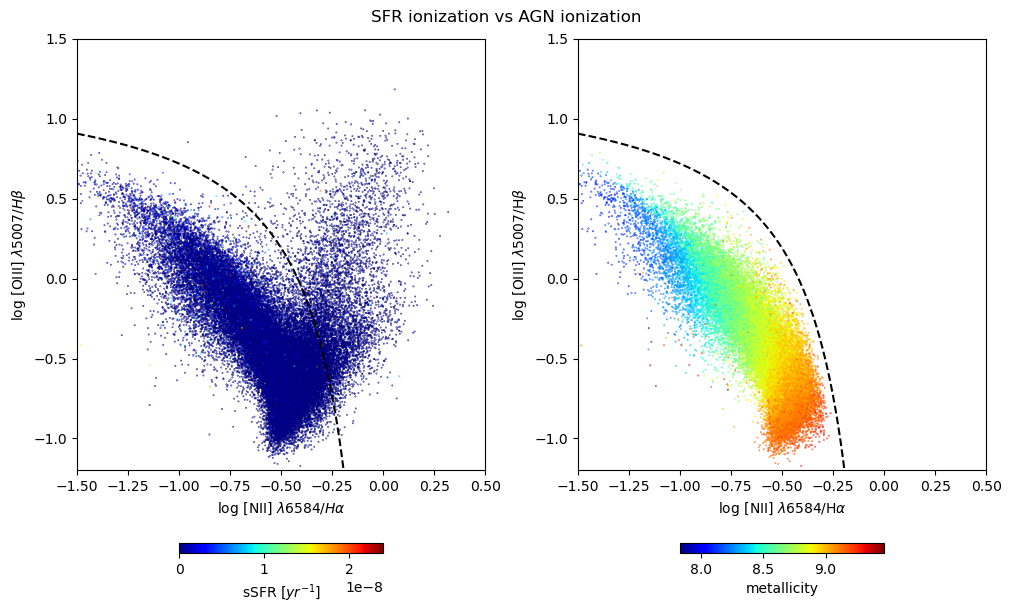

In [79]:
#log NII/Halpha vs log OIII/Hbeta

log_NII_Halpha = [] ; log_OIII_Hbeta = [] ; ssfr = [] ; met = []

StN = 5
AGN = [] #true if galaxy is an AGN, false elsewhere

for i in range(92483):
    if H_alpha[i]/H_alpha_err[i]>StN and H_beta[i]/H_beta_err[i]>StN and OIII_5007[i]/OIII_5007_err[i]>StN and NII_6584[i]/NII_6584_err[i]>StN:
        log_NII_Halpha.append(np.log10(NII_6584[i]/H_alpha[i]))
        log_OIII_Hbeta.append(np.log10(OIII_5007[i]/H_beta[i])) 
        ssfr.append(SFR_best[i]/stellar_mass_best[i])
        met.append(metallicity[i])
        if np.log10(OIII_5007[i]/H_beta[i])>0.61/(np.log10(NII_6584[i]/H_alpha[i])-0.05)+1.3: AGN.append(True)
        else: AGN.append(False)
    else: AGN.append(None)

AGN = np.array(AGN)

log_NII_Halpha = np.array(log_NII_Halpha) ; log_OIII_Hbeta = np.array(log_OIII_Hbeta) ; sSFR_best = np.array(sSFR_best) ; met = np.array(met)

x=np.linspace(-1.5,0.,1000) ##

fig, axes = plt.subplots(1, 2, figsize=(10,6),layout="constrained") 
fig.suptitle('SFR ionization vs AGN ionization') #fontsize=12
scat1 = axes[0].scatter(log_NII_Halpha, log_OIII_Hbeta, c = ssfr, cmap = cm.jet, s=0.1) #c = [np.log(galaxy.galactic_environment_bin(N,bins)) for galaxy in SDSS_galaxies]
axes[0].plot(x,0.61/(x-0.05)+1.3,linestyle='dashed',c='black')
axes[0].set_xlim(-1.5,0.5) ; axes[0].set_ylim(-1.2,1.5)
axes[0].set_xlabel("log [NII] $\lambda 6584/H \\alpha$") ; axes[0].set_ylabel("log [OIII] $\lambda 5007/H \\beta$")
fig.colorbar(scat1, ax=axes[0], location='bottom', shrink=0.5, label="sSFR [$yr^{-1}$]")

scat2 = axes[1].scatter(log_NII_Halpha[met>-9999], log_OIII_Hbeta[met>-9999], c = met[met>-9999], cmap = cm.jet, s=0.1)
axes[1].set_xlabel("log [NII] $\lambda$6584/H$\\alpha$") ; axes[1].set_ylabel("log [OIII] $\lambda$5007/H$\\beta$")
axes[1].plot(x,0.61/(x-0.05)+1.3,linestyle='dashed',c='black')
axes[1].set_xlim(-1.5,0.5) ; axes[1].set_ylim(-1.2,1.5)
fig.colorbar(scat2, ax=axes[1], location='bottom', shrink=0.5, label='metallicity')
plt.show()


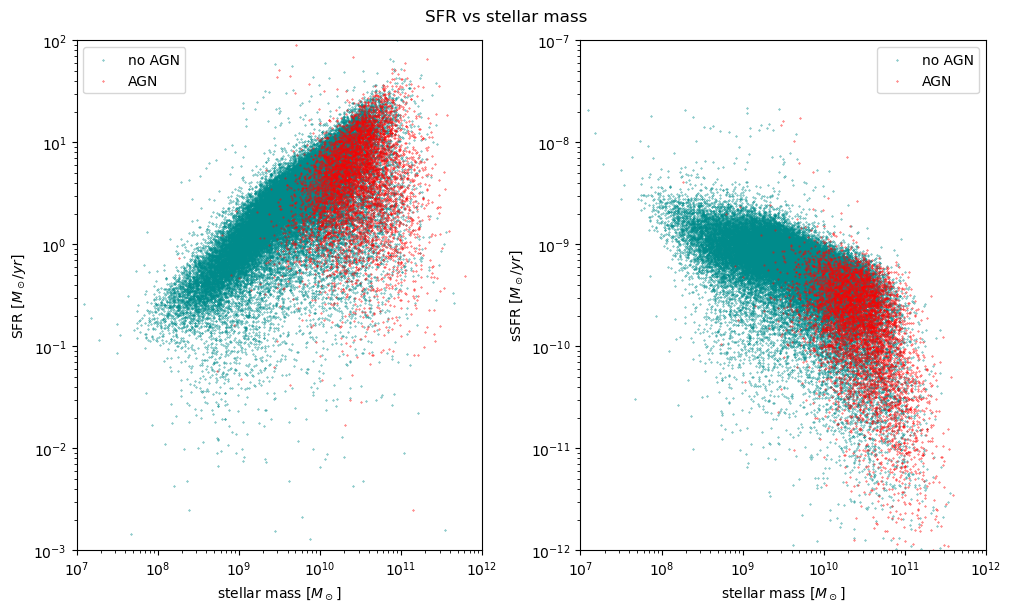

In [80]:
#SFR and sSFR vs Stellar Mass, AGN
fig, axes = plt.subplots(1, 2, figsize=(10,6),layout="constrained") 
fig.suptitle('SFR vs stellar mass') #fontsize=12

axes[0].scatter(stellar_mass_bayes[AGN==False],SFR_bayes[AGN==False], c = 'darkcyan', s=0.1, label = 'no AGN') #[AGN==False]
axes[0].scatter(stellar_mass_bayes[AGN==True],SFR_bayes[AGN==True], c = 'r', s=0.1, label = 'AGN')
axes[0].set_xscale('log') ; axes[0].set_yscale('log')
axes[0].set_xlim(10**7,10**12) ; axes[0].set_ylim(10**-3,10**2)
axes[0].set_xlabel("stellar mass [$M_\odot$]") ; axes[0].set_ylabel("SFR [$M_\odot/yr$]")
axes[0].legend()

axes[1].scatter(stellar_mass_bayes[AGN==False],sSFR_bayes[AGN==False], c = 'darkcyan', s=0.1, label = 'no AGN') #[AGN==False]
axes[1].scatter(stellar_mass_bayes[AGN==True],sSFR_bayes[AGN==True], c = 'r', s=0.1, label = 'AGN')
#axes[1].scatter(stellar_mass[AGN==None],SFR[AGN==None], c = 'r', s=0.1, label = 'AGN')
axes[1].set_xscale('log') ; axes[1].set_yscale('log')
axes[1].set_xlim(10**7,10**12) ; axes[1].set_ylim(10**-12,10**-7)
axes[1].set_xlabel("stellar mass [$M_\odot$]") ; axes[1].set_ylabel("sSFR [$M_\odot/yr$]")
#axes[1].scatter(stellar_mass,sSFR, c = 'g', s=0.1)
#axes[1].set_xscale('log') ; axes[1].set_yscale('log')
#axes[1].set_xlim(10**7,10**12) ; axes[1].set_ylim(10**-12,10**-7)
#axes[1].set_xlabel("stellar mass [$M_\odot$]") ; axes[1].set_ylabel("sSFR [$yr^{-1}$]")
axes[1].legend()
plt.show()

In [36]:
#using our fit and not Fossati
cigale_fit_results_bis = Table.read('results.fits')

SFR_bayes = cigale_fit_results_bis['bayes.sfh.sfr']
stellar_mass_best = cigale_fit_results_bis['best.stellar.m_star']
gas_mass_best = cigale_fit_results_bis['best.stellar.m_gas']

m_gas_m_stellar_ratio = gas_mass_best/stellar_mass_best

 log_oh 
--------
8.734623
8.811741
8.746394
8.598006
8.476838
 8.85442
8.610314
     ...
8.678088
8.986331
9.092475
8.774762
8.615378
9.109709
9.002823
Length = 38055 rows


NameError: name 'NEIcoords' is not defined

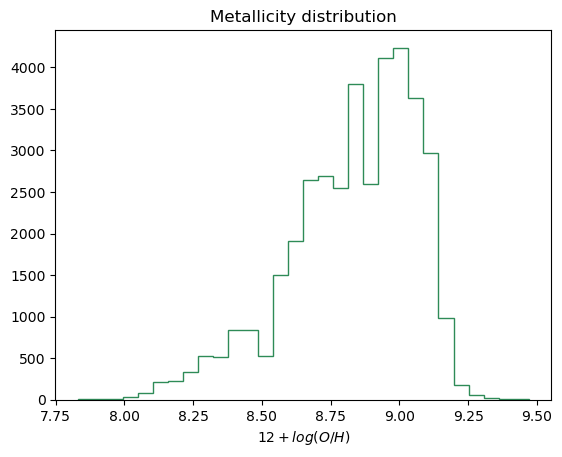

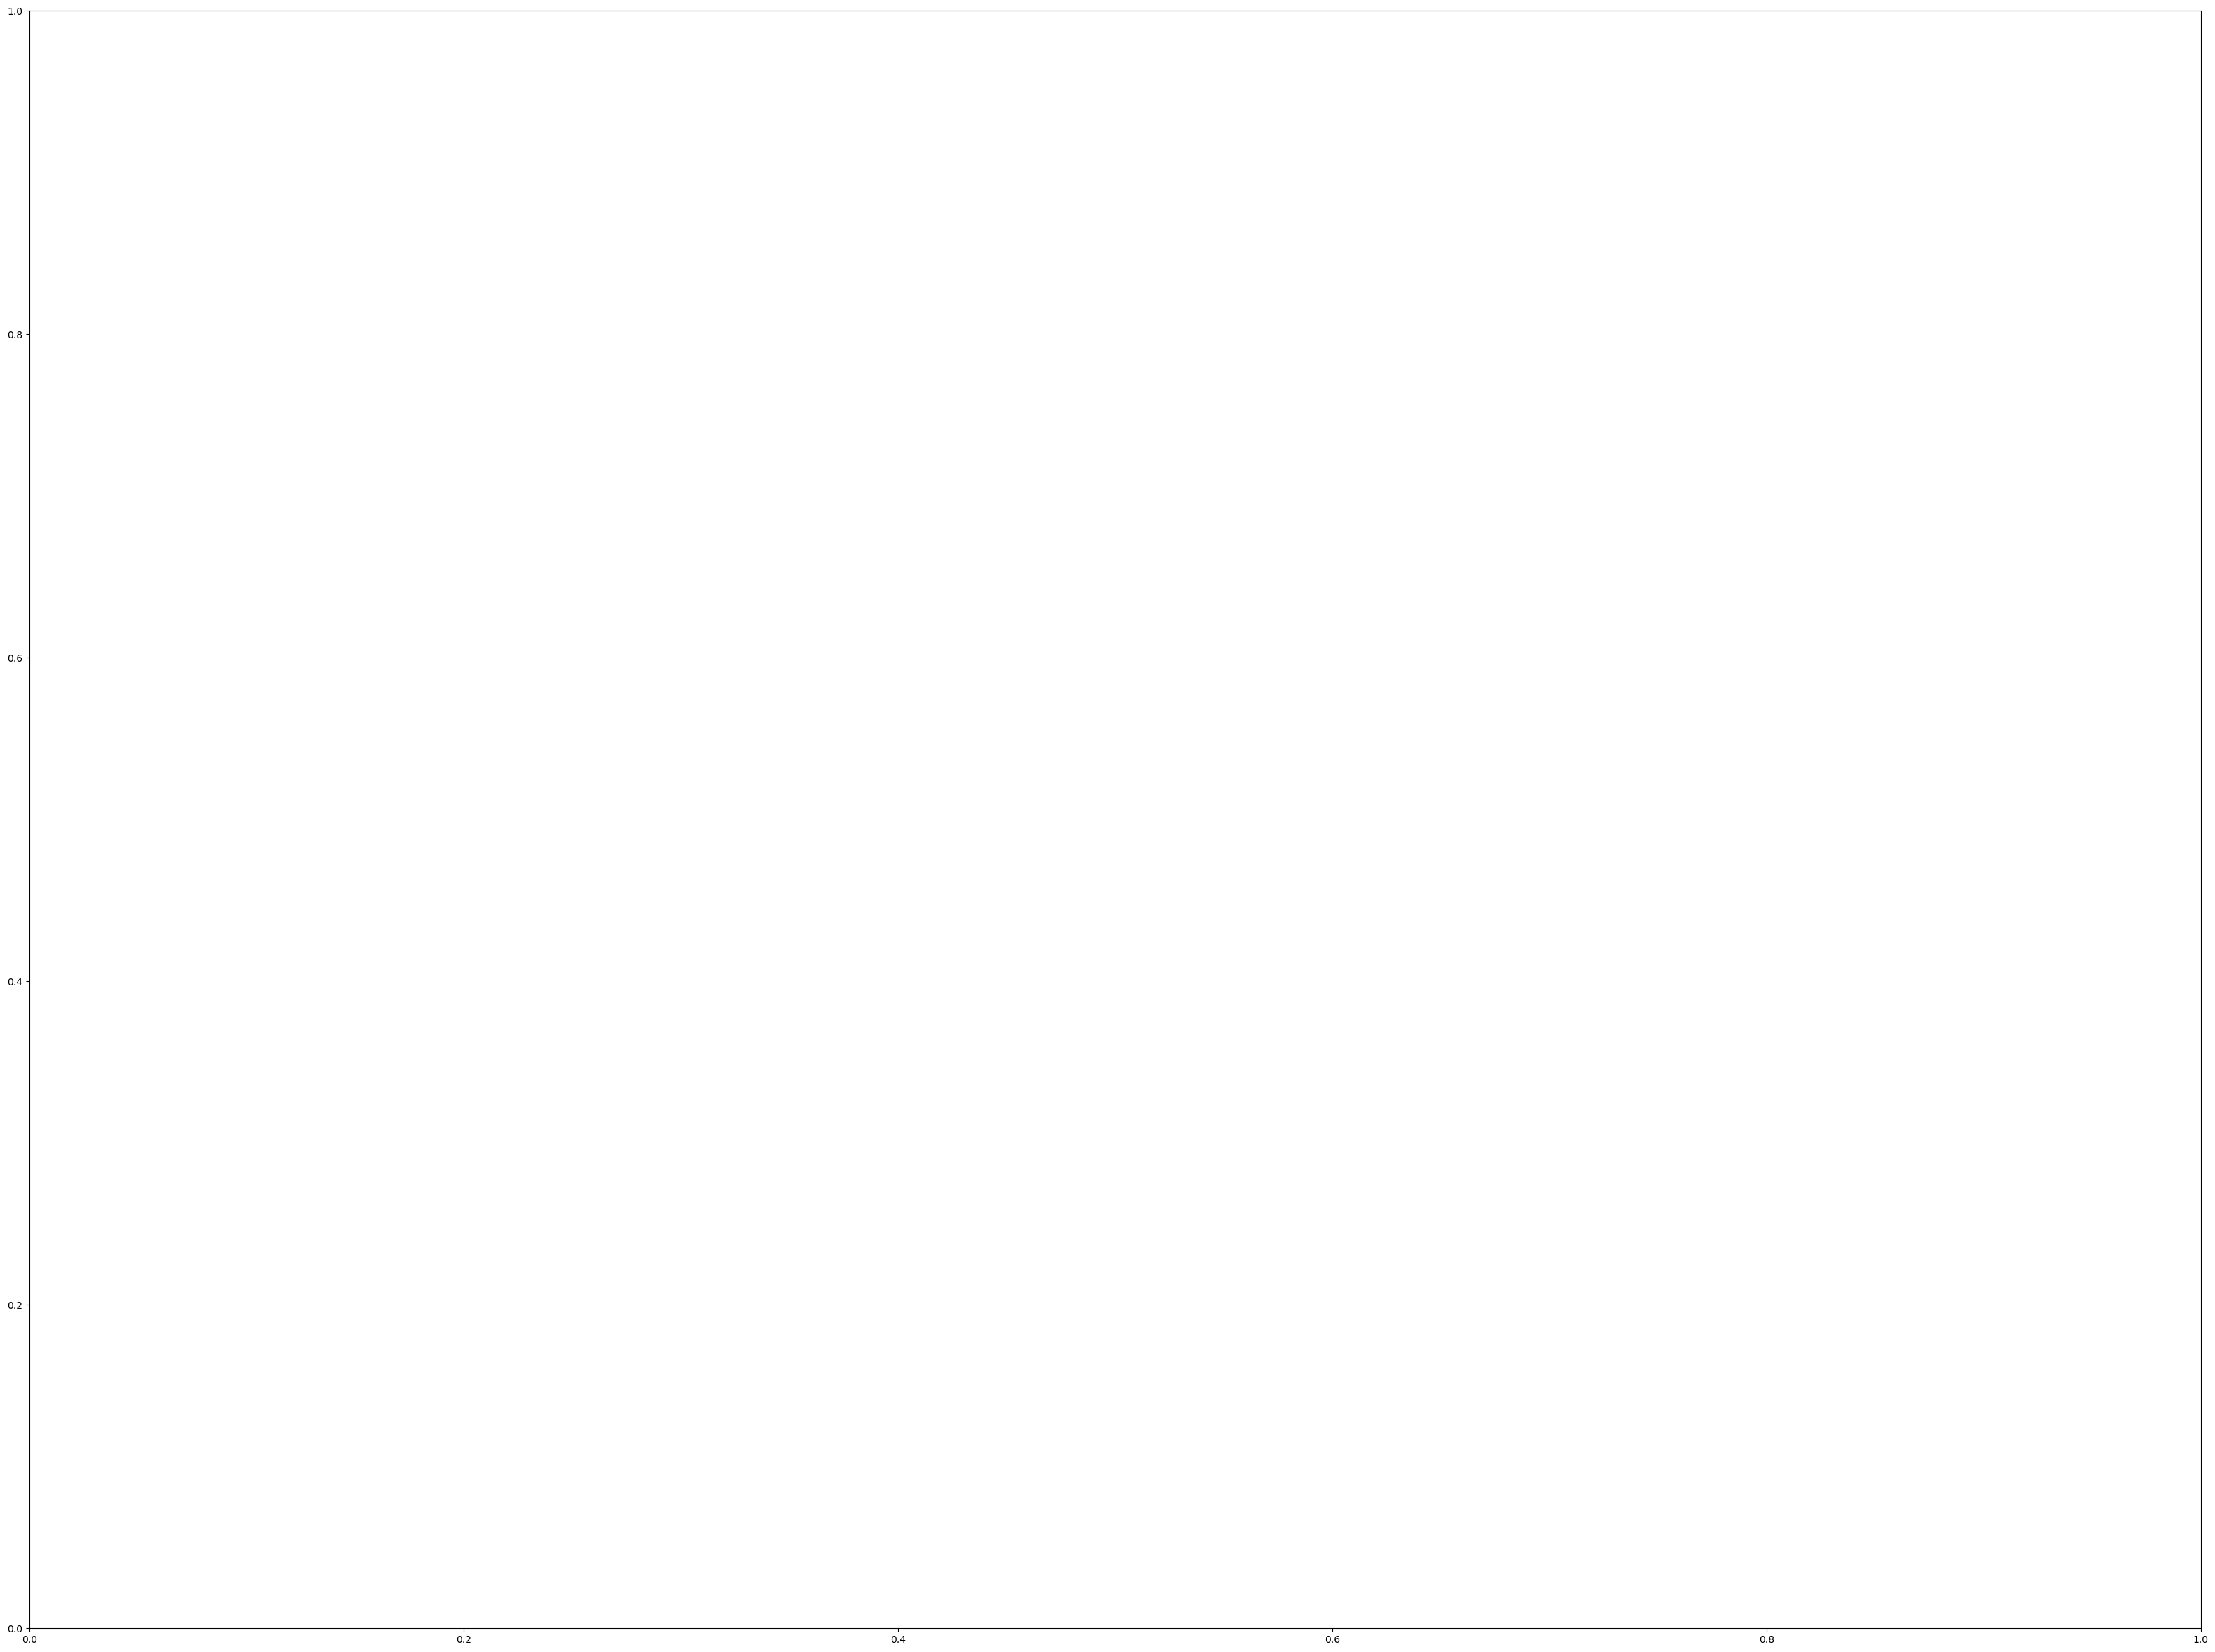

In [69]:



metal_plot = metallicity[metallicity > -9999.]
print(metal_plot)
plt.hist(metal_plot, bins = 30, color = 'g', histtype='step', edgecolor= 'seagreen')
plt.title("Metallicity distribution")
plt.xlabel("$12 + log(O/H)$")

# plt.figure(figsize = (20, 20))
# plt.scatter(N_2 / H_alpha, O_3 / H_beta)
# plt.xticks(size = 35)
# plt.yticks(size = 35)
# plt.ylabel("NII / H_$_\\alpha$", size = 40) 
# plt.xlabel("OIII / H_$_\\beta$", size = 40) 
# plt.xscale("log")
# plt.yscale("log")
# plt.xlim(1e-5, 1e2)
# plt.ylim(1e-5, 1e2)

density = (1 / (np.pi * 0.5**2)) * N #Mpc

fig = plt.figure(figsize=(40, 30))
ax = fig.add_subplot()

plt.scatter(NEIcoords.ra, NEIcoords.dec, marker=".", alpha=0.7, c=density, cmap="viridis")
cbar = plt.colorbar(pad=0.01)
cbar.ax.tick_params(labelsize=35)
plt.clim(0, 10)
plt.xticks(size=35)
plt.yticks(size=35)
plt.xlabel("RA [hours]", size=40)
plt.ylabel("DEC [deg]", size=40)


In [ ]:
**STAR FORMATION RATE**

ISM content: 80% H, 20% H2, 1% dust. Molecular fraction increases with increasing densities.

Star formation occurs in giant molecular clouds ($10^6-10^6M_\odot$, $\approx 10-100$pc, $n_{H_2}\approx 100-500$cm^-3, $\rho\approx 10^{-21}$ gcm^-3, $T\approx 10$ K) that can be traced by CO lines. Temperature, apart from regions close to hot O,B stars which are heated by UV radiation, is homogeneus: cosmic rays are the main heating source.

Star formation is found to occur only in the most massive clumps (star clusters) and cores (single stars). Why the star formation efficiency is so low?

GMC have high level of supersonic turbulence (from broadening of spectral lines). Their typical lifetime is $\approx 10^7$ yrs.

Bonnor Erbert mass (Jeans mass): 

$$M_{BE}=1.182\frac{c_s^3}{(G^3\rho)^{1/2}}$$

GMC are much more massive than this limit: there must be some form of pressure other than thermal supporting them against collapse. $M_{BE}=1.182\frac{(c_s^2+\sigma^2)^3}{(G^3\rho)^{1/2}}$.
This accounts for isotropic turbolent motion.

Equating magnetic energy with potential energy:

$$M_{\Phi}=1.6\times 10^5 M_\odot (n_{H_2}/100cm^{-3})^{-2}(B/30\mu G)^3$$

The main formation mechanism of $H_2$ in ISM is recombination of pairs of adsorbed hydrogen atoms on the surface of dust grains: $t_{form}\approx1.5\times 10^7 yrs(n/100 cm^{-3})^{-1}$ mush more efficient than gas phase reactions. Main destruction process is photodissociation. 

$$\frac{n_{H_2}}{n_{HI}}\propto P_{ext}^{2.2}j^{-1}$$

Assuming $j$ proportional to star formation rate per unit surface density $\dot{\Sigma}_* \propto \Sigma_{H_2}\approx\frac{n_{H_2}}{n_{HI}}\Sigma_{gas}$:


**Two theories of GMC formation**



$$\dot{\Sigma}_*\propto\Sigma_{gas}^N$$

$$\dot{\Sigma}_*=(2.5\times 10^{-4})(\Sigma_{gas}/M_\odot pc^-2)^{1.4}M_\odot yrs^{-1} kpc^{-2}$$ 

In [ ]:
**STAR FORMATION RATE**

ISM content: 80% H, 20% H2, 1% dust. Molecular fraction increases with increasing densities.

Star formation occurs in giant molecular clouds ($10^6-10^6M_\odot$, $\approx 10-100$pc, $n_{H_2}\approx 100-500$cm^-3, $\rho\approx 10^{-21}$ gcm^-3, $T\approx 10$ K) that can be traced by CO lines. Temperature, apart from regions close to hot O,B stars which are heated by UV radiation, is homogeneus: cosmic rays are the main heating source.

Star formation is found to occur only in the most massive clumps (star clusters) and cores (single stars). Why the star formation efficiency is so low?

GMC have high level of supersonic turbulence (from broadening of spectral lines). Their typical lifetime is $\approx 10^7$ yrs.

Bonnor Erbert mass (Jeans mass): 

$$M_{BE}=1.182\frac{c_s^3}{(G^3\rho)^{1/2}}$$

GMC are much more massive than this limit: there must be some form of pressure other than thermal supporting them against collapse. $M_{BE}=1.182\frac{(c_s^2+\sigma^2)^3}{(G^3\rho)^{1/2}}$.
This accounts for isotropic turbolent motion.

Equating magnetic energy with potential energy:

$$M_{\Phi}=1.6\times 10^5 M_\odot (n_{H_2}/100cm^{-3})^{-2}(B/30\mu G)^3$$

The main formation mechanism of $H_2$ in ISM is recombination of pairs of adsorbed hydrogen atoms on the surface of dust grains: $t_{form}\approx1.5\times 10^7 yrs(n/100 cm^{-3})^{-1}$ mush more efficient than gas phase reactions. Main destruction process is photodissociation. 

$$\frac{n_{H_2}}{n_{HI}}\propto P_{ext}^{2.2}j^{-1}$$

Assuming 

In [ ]:
#SFR vs stellar mass vs Metallicity

fig, axes = plt.subplots(1, 2, figsize=(10,6),layout="constrained") 
fig.suptitle('SFR vs stellar mass') #fontsize=12
S = axes[0].scatter(stellar_mass[metallicity>-9999],SFR[metallicity>-9999], c = metallicity[metallicity>-9999], cmap = cm.jet, s=0.1)
axes[0].set_xscale('log') ; axes[0].set_yscale('log')
axes[0].set_xlim(10**7,10**12) ; axes[0].set_ylim(10**-3,10**2)
axes[0].set_xlabel("stellar mass [$M_\odot$]") ; axes[0].set_ylabel("SFR [$M_\odot/yr$]")

axes[1].scatter(stellar_mass[metallicity>-9999],sSFR[metallicity>-9999], c = metallicity[metallicity>-9999], cmap = cm.jet, s=0.1)
axes[1].set_xscale('log') ; axes[1].set_yscale('log')
axes[1].set_xlim(10**7,10**12) ; axes[1].set_ylim(10**-12,10**-7)
axes[1].set_xlabel("stellar mass [$M_\odot$]") ; axes[1].set_ylabel("sSFR [$yr^{-1}$]")
fig.colorbar(S, ax=axes, location='bottom', shrink=0.5, label='metallicity')
plt.show()

In [ ]:
#SFR vs Stellar Mass, AGN
fig, axes = plt.subplots(1, 2, figsize=(10,6),layout="constrained") 
fig.suptitle('SFR vs stellar mass') #fontsize=12

stellar_mass_AGN = stellar_mass[AGN==True]
SFR_AGN = SFR[AGN==True]
stellar_mass_noAGN = stellar_mass[AGN==False]
SFR_noAGN = SFR[AGN==False]
metallicity_AGN = metallicity[AGN==True]
metallicity_noAGN = metallicity[AGN==False]


S = axes[0].scatter(stellar_mass_noAGN[metallicity_noAGN>-9999],SFR_noAGN[metallicity_noAGN>-9999], c = metallicity_noAGN[metallicity_noAGN>-9999], s=0.1, label = 'no AGN') #[AGN==False]
#axes[0].scatter(stellar_mass[AGN==True],sSFR[AGN==True], c = 'r', s=0.1, label = 'AGN')
axes[0].set_xscale('log') ; axes[0].set_yscale('log')
#axes[0].set_xlim(10**7,10**12) ; axes[0].set_ylim(10**-3,10**2)
axes[0].set_xlabel("stellar mass [$M_\odot$]") ; axes[0].set_ylabel("SFR [$M_\odot/yr$]")
axes[0].legend()

axes[1].scatter(stellar_mass_AGN[metallicity_AGN>-9999],SFR_AGN[metallicity_AGN>-9999], c = metallicity_AGN[metallicity_AGN>-9999], s=0.1, label = 'AGN') #[AGN==False]
#axes[1].scatter(stellar_mass[AGN==None],SFR[AGN==None], c = 'r', s=0.1, label = 'AGN')
axes[1].set_xscale('log') ; axes[1].set_yscale('log')
axes[1].set_xlim(10**7,10**12) ; axes[1].set_ylim(10**-3,10**2)
axes[1].set_xlabel("stellar mass [$M_\odot$]") ; axes[0].set_ylabel("SFR [$M_\odot/yr$]")
#axes[1].scatter(stellar_mass,sSFR, c = 'g', s=0.1)
#axes[1].set_xscale('log') ; axes[1].set_yscale('log')
#axes[1].set_xlim(10**7,10**12) ; axes[1].set_ylim(10**-12,10**-7)
#axes[1].set_xlabel("stellar mass [$M_\odot$]") ; axes[1].set_ylabel("sSFR [$yr^{-1}$]")
axes[1].legend()

fig.colorbar(S, ax=axes, location='bottom', shrink=0.5, label='metallicity')

plt.show()